# Sex Demographics

In [1]:
#import
import multiprocessing
import re 
import math
from collections import Counter

import feather
import matplotlib as mpt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.plotly as py
import scipy as sc
import seaborn as sns
import pickle
from jupyterthemes import jtplot
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

jtplot.style(
    theme='grade3',
    context='paper',
    fscale=1.4,
    spines=True,
    gridlines='--',
    ticks=True,
    grid=False,
    figsize=(6, 4.5))

#mpt.rcParams

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

ROOT = "/Users/payalchandak/Not On Dropbox/Data/Sex Demographics/" 

## Previous

### Cleaning, Mapping and Chi Square

In [ ]:
df = pd.read_feather(ROOT + "AEOLUS/aeolus_Nick.tsv.feather")

In [ ]:
# Cleaning 

#Drop irrelevant columns 
df=df.drop(labels=[ 
    'drug_outcome_name',
    'aed',
    'age_cat', 
    'tot_drug_outcomes',
    'drug_marginal',
    'outcome_marginal',
    'a',
    'b',
    'c',
    'd',
    'N',
    'RRR',
    'ROR',
    'PRR',
    'IC',
    'IC_posterior_expectation',
    ], axis=1) 

#Capitalize to title case 
df['drug_concept_name'] = df['drug_concept_name'].apply(lambda x: str(x).title())
df['outcome_concept_name'] = df['outcome_concept_name'].apply(lambda x: str(x).title())

#clean aeolus gender ~ only keep M and F 
df = df.query('gender_code=="M" or gender_code=="F"')

#write to file
df.reset_index().drop('index',axis=1).to_feather(ROOT+"AEOLUS/clean_withRank.tsv.feather")

In [ ]:
#Snomed-Meddra-Outcome Severity Mapping and adding to 'df'  

outMap = pd.read_csv(ROOT + "Outcome Severity Mapping/MEDDRA SNOMED.txt", delimiter="\t")
outRank = pd.read_excel(ROOT + 'Outcome Severity Mapping/Ranked ADRs.xlsx', sheet_name='Ranked ADRs')

#creating outcomes table with unique outcomes and ranks
#assigns -1 for unmapped 
#assigns 0 for unranked

outcomes = df.loc[:, ['snomed_outcome_concept_id']].drop_duplicates(
).reset_index().loc[:, ['snomed_outcome_concept_id']]
outcomes["outcome_rank"] = np.nan
numOutcomes = outcomes['snomed_outcome_concept_id'].count()

for i in range(0, numOutcomes):
    snowID = outcomes.at[i, 'snomed_outcome_concept_id']
    mapQ = outMap.query('snomed_concept_id == @snowID')
    if mapQ.empty:
        outcomes.at[i, 'outcome_rank'] = -1
    else:
        medName = mapQ.reset_index().loc[0, 'meddra_concept_name'].upper()
        rankQ = outRank.query('Name == @medName')
        if rankQ.empty:
            outcomes.at[i, 'outcome_rank'] = 0
        else:
            outcomes.at[i, 'outcome_rank'] = rankQ.reset_index().at[
                0, 'Rank score']

#Putting outcome ranks in main dataframe
df = df.sort_values(by='snomed_outcome_concept_id')
outcomes = outcomes.sort_values(by='snomed_outcome_concept_id')
df["outcome_rank"] = np.nan
temp_snowID = 0
temp_rank = 0
numPatients = df['id'].count()

for i in range(0, numPatients):
    df_snowID = df.at[i, 'snomed_outcome_concept_id']
    if (temp_snowID != df_snowID):
        temp_outcomes = outcomes.query(
            'snomed_outcome_concept_id == @df_snowID').reset_index()
        temp_rank = temp_outcomes.at[0, 'outcome_rank']
        temp_snowID = temp_outcomes.at[0, 'snomed_outcome_concept_id']
    df.at[i, 'outcome_rank'] = temp_rank

#display counts of outcome ranks
#df.loc[:,['id','outcome_rank']].groupby('outcome_rank').count().sort_values(by='id',ascending=False)

In [ ]:
# Add usagi mapped outcome rankings to AEOLUS !!!! SOME ARE NaN   

df=df_aeolus
outcomes = pd.read_feather(ROOT+"Outcome Severity Mapping/SNOMED Mapped Severity.feather")

df = df.sort_values(by='snomed_outcome_concept_id')
outcomes = outcomes.sort_values(by='snomed_id')
df["outcome_rank"] = np.nan
temp_snoID = 0
temp_rank = 0
numPatients = df['id'].count()

for i in range(0, numPatients):
    df_snoID = df.at[i, 'snomed_outcome_concept_id']
    if (temp_snoID != df_snoID):
        temp_outcomes = outcomes.query(
            'snomed_id == @df_snoID').reset_index()
        temp_rank = temp_outcomes.at[0, 'severity_rank']
        temp_snoID = temp_outcomes.at[0, 'snomed_id']
    df.at[i, 'outcome_rank'] = temp_rank
    
df=df.reset_index()
df.to_feather(ROOT+"AEOLUS/AEOLUS_clean_ranked.feather")

#### Chi2 with Multiprocessing

In [217]:
#returns chi2, p value 
i = 0
 

def doChiSquare(self):
    drugID = self[0]
    outcomeID = self[1]
    df_temp = df.query('drug_concept_id==@drugID')\
                .loc[:,['drug_concept_id', 'snomed_outcome_concept_id','gender_code']]
    M_All = df_temp.query('gender_code=="M"').shape[0]
    F_All = df_temp.query('gender_code=="F"').shape[0]
    df_temp = df_temp.query('snomed_outcome_concept_id==@outcomeID')
    M_One = df_temp.query('gender_code=="M"').shape[0]
    F_One = df_temp.query('gender_code=="F"').shape[0]
    if ((not M_All == 0) and (not F_All == 0) and (not M_One == 0)
            and (not F_One == 0)):
        contingencyTable = [[F_One, M_One], [F_All, M_All]]
    else:
        contingencyTable = [[1, 1], [1, 1]]
    chi2, p, dof, expected = sc.stats.chi2_contingency(contingencyTable)
    global i
    i += 1
    print(i)
    return float(chi2), float(p), M_One, F_One, M_All, F_All

In [ ]:
#SETTING UP DATAFRAME FOR MULTIPROCESSING  

#Single drug ADR pairs
drugID = 1367571  #Heparin
np_heparin_adrPairs = df.query('drug_concept_id == @drugID')\
                .loc[:,['drug_concept_id','snomed_outcome_concept_id', 'drug_concept_name','outcome_concept_name','ROR','outcome_rank']]\
                .drop_duplicates()\
                .values
#All drugs adr pairs:
np_all_adrPairs = df.sort_values(by='drug_concept_id')\
                .loc[:,['drug_concept_id','snomed_outcome_concept_id', 'drug_concept_name','outcome_concept_name','ROR','outcome_rank']]\
                .drop_duplicates()\
                .values
#len(np_all_adrPairs) #-- 264023

In [ ]:
#MULTIPROCESSING  
dfMulti_input = batch8 

numProcesses = 16
pool = multiprocessing.Pool(processes=numProcesses)

result = pool.map(doChiSquare, dfMulti_input)
pool.close()

names = [[
    "drug_concept_id", "snomed_outcome_concept_id", "drug_concept_name",
    "outcome_concept_name", "ROR", "outcome_rank", "chi2_stat", "p_value",
    "M_One", "F_One", "M_All", "F_All"
]]
data = np.concatenate((dfMulti_input, result), axis=1)
dfMulti_output = pd.DataFrame(data=data, columns=names)
dfMulti_output.to_feather("250000-.feather")
batch8 = dfMulti_output

### Processing Individual Associations

#### Calculation Functions

In [ ]:
df_chi2 = pd.read_feather(ROOT + "Stages/Chi2 Results.feather")

In [2]:
#functions


#Sample Size
def sampleSize(df):
    sampleSizes = df['M_One'] + df['F_One']
    return df.assign(sample_size=sampleSizes)


#Gender Assignment
def gender(df):
    gender_val = df['M_One'] - df['F_One']
    gender_val = gender_val.mask(gender_val > 0, "Male").mask(
        gender_val < 0, "Female").mask(gender_val == 0, "Equal")
    return df.assign(gender=gender_val)


#Bonferroni Correction
def bonferroni(df, colName='p_value'):
    p_values = pd.to_numeric(df[colName])
    bonferroni_pvalues = p_values * len(p_values)
    df = df.assign(newCol=bonferroni_pvalues)
    newCol = 'bonf_' + colName
    return df.rename(columns={'newCol': newCol})


#gender specific reporting odds ratio, likelihood ratio and relative risk (with normalised)
def riskFactor(df, factor, normal=True):
    ALLOWED_FACTORS = ['ROR', 'LR', 'RR']
    if factor not in ALLOWED_FACTORS:
        raise valueError(
            "Invalid factor. Expected one of: %s" % ALLOWED_FACTORS)

    a = df['gender'].mask(df['gender'] == "Male", df['M_One']).mask(
        df['gender'] == "Female", df['F_One']).mask(df['gender'] == "Equal", 1)
    b = df['gender'].mask(df['gender'] == "Male", df['M_All']).mask(
        df['gender'] == "Female", df['F_All']).mask(df['gender'] == "Equal", 1)
    b = b - a
    c = df['gender'].where(df['gender'] == "Male", df['M_One']).where(
        df['gender'] == "Female", df['F_One']).mask(df['gender'] == "Equal", 1)
    d = df['gender'].where(df['gender'] == "Male", df['M_All']).where(
        df['gender'] == "Female", df['F_All']).mask(df['gender'] == "Equal", 1)
    d = d - c

    a = a.mask(a == 0, 1)
    b = b.mask(b == 0, 1)
    c = c.mask(c == 0, 1)
    d = d.mask(d == 0, 1)

    
    if (factor == "ROR"):
        x = (a / b) / (c / d)
    elif (factor == "LR"):
        x = (a / (a + c)) / (b / (b + d))
    elif (factor == "RR"):
        x = (a / (a + b)) / (c / (c + d))

    x = pd.to_numeric(x)
    name = "gender_" + factor
    df = df.assign(new=x).rename(columns={'new': name})
    df.astype(dtype={name:"float64"})
    

    if (normal):
        x_normal = (x - min(x)) / (max(x) - min(x))
        name_normal = "gender_" + factor + "_normal"
        df = df.assign(new_normal=x_normal).rename(
            columns={'new_normal': name_normal})
        df.astype(dtype={name_normal:"float64"})
    
    
    return df

In [ ]:
#applying functions

df_genderAsso = sampleSize(gender(bonferroni(df_chi2)))

for f in ['ROR', 'LR', 'RR']:
    df_genderAsso = riskFactor(df=df_genderAsso, factor=f)

df_genderAsso_sig = df_genderAsso.query('bonf_p_value<=0.05')

#### Volcano Plot

In [ ]:
#MAKING THE VOLCANO PLOT 

df_input = df_genderAsso_sig

#Puts 1 for Female, -1 for Male into Gender Code
df_genderVolcano = df_input.assign(gender_code=0)
df_genderVolcano['gender_code'].mask(
    df_genderVolcano['gender'] == "Male", -1, inplace=True)
df_genderVolcano['gender_code'].mask(
    df_genderVolcano['gender'] == "Female", 1, inplace=True)
 
#Make x and y
df_genderVolcano = df_genderVolcano.assign(
    x=((np.log2(pd.to_numeric(df_input['gender_ROR']))) *
       (df_genderVolcano['gender_code'])))
df_genderVolcano = df_genderVolcano.assign(
    y=(np.log10(pd.to_numeric(df_input['adjusted_p_value'])) * (-1)))
df_genderVolcano = df_genderVolcano.query('x<-1').append(
    df_genderVolcano.query('x>1'))

sns.set_context("paper", font_scale=1.3)
plot = sns.lmplot(
    x='x',
    y='y',
    data=df_genderVolcano,
    fit_reg=False,
    hue='gender',
    legend=True,
    scatter_kws={'alpha': 0.7})
plt.ylabel("-Log10(Adjusted P Value)")
plt.xlabel("Log2(ROR)")
plt.title("Significant Gender Signals for Adverse Drug Events")
plt.hlines(0.05, -10, 10)
plt.vlines(-1, -5, 250)
plt.vlines(1, -5, 250)
plt.show()

In [ ]:
#VOLCANO PLOT DESCRIPTIVE STATS 

highestPoints = df_genderVolcano.sort_values(
    by='y', ascending=False).reset_index()[0:15]

top20drugs = df_genderVolcano.groupby('drug_concept_name').count().sort_values(
    by='y',
    ascending=False)['drug_concept_id']['Aspirin':'Lisinopril'].reset_index()

plot = sns.barplot(
    x=top20drugs.drug_concept_id,
    y=top20drugs.drug_concept_name,
    color='black')
plt.ylabel("Drug Name")
plt.xlabel("Number of Gender Associations")
plt.title("Top 20 Drugs with most Gender Associations")
plt.show()

top20outcomes = df_genderVolcano.groupby(
    'outcome_concept_name').count().sort_values(
        by='y', ascending=False)['drug_concept_id'][
            'Alopecia':'Gynecomastia'].reset_index()

plot = sns.barplot(
    x=top20outcomes.drug_concept_id,
    y=top20outcomes.outcome_concept_name,
    color='black')
plt.ylabel("Outcome Name")
plt.xlabel("Number of Gender Associations")
plt.title("Top 20 Outcomes with most Gender Associations")
plt.show()

#### Removing Gender-Specific Outcomes

In [ ]:
#REMOVING ALL GENDER BIASED OUTCOMES FROM DFTestic 

def removeBiasedOutcomes(df):
    outcomeNames = df['outcome_concept_name'].unique()
    ls_outToIgnore = []
    for name in outcomeNames:
        if (re.search(
                'pregnan|lactat|vagina|female|breast|contracep|ovary|miscarr|menopaus',
                name, re.IGNORECASE)):
            ls_outToIgnore = np.append(ls_outToIgnore, name)
        if (re.search('prostate|penis|ejac|testoster|testicu', name, re.IGNORECASE)):
            ls_outToIgnore = np.append(ls_outToIgnore, name)
        if (re.search('fetus|fetal|neonat|antenat|gestati|birth', name,
                      re.IGNORECASE)):
            ls_outToIgnore = np.append(ls_outToIgnore, name)
        if (re.search(
                'traffic|gunshot|homicide|education|noncompliance|error|annual.review',
                name, re.IGNORECASE)):
            ls_outToIgnore = np.append(ls_outToIgnore, name)
    return df[-df['outcome_concept_name'].isin(ls_outToIgnore)]


df_genderAsso_sig = removeBiasedOutcomes(df_genderAsso_sig)

#### Adding Missing Severity Ranks

In [ ]:
#ADDING MANUALLY MAPPED RANKS FOR MISSING DATA

def addDictRanks(df, rankDict, rankData):
    for i in df.index:
        currentRank = df.at[i, 'outcome_rank']
        if ((currentRank == -1) or (currentRank == 0)):
            searchName = df.at[i, 'outcome_concept_name']
            rankName = rankDict.query('outcome_concept_name==@searchName')[
                'crowdsourced_name']
            if (not rankName.empty):
                rankName = rankName.item()
                newRank = outRank.query('Name==@rankName')['Rank score']
                df.at[i, 'outcome_rank'] = newRank


outRank = pd.read_excel(ROOT + 'Outcome Severity Mapping/Ranked ADRs.xlsx', sheet_name='Ranked ADRs')
df_rankDict = pd.read_feather(ROOT + "Outcome Severity Mapping/Outcomes Dictionary.feather")
addDictRanks(df_genderAsso_sig, rankDict=df_rankDict, rankData=outRank)

In [ ]:
# Check if outcome ranks are missing and if yes, set up regEx search 

outRank = pd.read_excel(ROOT + 'Outcome Severity Mapping/Ranked ADRs.xlsx', sheet_name='Ranked ADRs')
df_rankDict = pd.read_feather(ROOT +"Outcome Severity Mapping/Outcomes Dictionary.feather")
rankNames = outRank.Name.unique()
rankNames = np.sort(rankNames)

toDo = df_genderAsso_sig.query('outcome_rank==0').reset_index()['outcome_concept_name'].unique()
done = df_rankDict['outcome_concept_name']

for i in range(0, len(done)):
    idx = np.argwhere(toDo == done[i])
    toDo = np.delete(toDo, idx)
#done = done[-1:]
if (len(toDo) == 0):
    print("All Done :)")
else:
    search = toDo[0]
    print(search)

In [ ]:
#RegEx search of crowdsourced dictionary

words = search.upper().replace(".", " ").split()
newWords = []
ignore = [
    'ABNORMAL', 'SYNDROME', 'DISORDERS', 'BY', 'ITS', 'REACTION', 'AND/OR',
    'RAISED', 'DECREASED', 'INCREASED', 'OF', 'AND', 'ON', 'DUE', "THE", 'TO',
    'IN', 'FROM', 'WITH', 'DISORDER', 'DISEASE'
]
for word in words:
    if word not in ignore:
        #word = word.rstrip(word[-2:])
        newWords.append(word)
reg = '|'.join(word for word in newWords)
for name in rankNames:
    if (re.search(reg, name)):
        #if (re.search('dil', name, re.IGNORECASE)):
        print(name)

In [ ]:
#Add snomed outcome name, crowdsourced outcome name to dictionary
found = "COMPRESSION FRACTURE"
names = ["outcome_concept_name", "crowdsourced_name"]
data = pd.DataFrame([[search, found]], columns=names)
if search not in df_rankDict.outcome_concept_name.values:
    df_rankDict = df_rankDict.append(data, ignore_index=True)
    df_rankDict.to_feather(ROOT+"Outcome Severity Mapping/Outcomes Dictionary.feather")
    done = np.append(done, search)
    df_rankDict[-1:]
else:
    print('already added')
    df_rankDict[-1:]

In [ ]:
df_rankDict[:-1].to_feather(ROOT+"Outcome Severity Mapping/Outcomes Dictionary.feather")

#### Adjusting for Universal Gender Bias

In [ ]:
#Calculating Outcome Gender Bias from scratch 

#READING INPUT DATAFRAMES ~ AEOLUS & OUTCOME IDs and Names
outcome_IDNAME = pd.read_feather(ROOT + 'AEOLUS/adrIDadrName_unique.feather')
df_aeolus = pd.read_feather(ROOT + "AEOLUS/clean_withRank.tsv.feather")

def getOutcomeBias(outcome_IDNAME):
    outcomeID = outcome_IDNAME.snomed_outcome_concept_id
    outcomeName = outcome_IDNAME.outcome_concept_name
    df_outcome = df_aeolus.query('snomed_outcome_concept_id == @outcomeID')
    a = np.sum([df_outcome['gender_code'] == "M"])
    c = np.sum([df_outcome['gender_code'] == "F"])
    b = 11193044  #len(df_aeolus[df_aeolus['gender_code']=="M"])
    d = 17688002  #len(df_aeolus[df_aeolus['gender_code']=="F"])

    if (a == 0 or c == 0):
        a = 1
        b = 1
        c = 1
        d = 1

    if (c > a):
        gender = "Female"
    else:
        gender = "Male"

    ROR = (a / b) / (c / d)
    LR = (a / (a + c)) / (b / (b + d))
    RR = (a / (a + b)) / (c / (c + d))

    contingencyTable = [[a, c], [b, d]]
    chi2, p, dof, expected = sc.stats.chi2_contingency(contingencyTable)

    data = np.array([
        outcomeID, outcomeName, a, c,
        float(chi2),
        float(p),
        float(ROR),
        float(LR),
        float(RR), gender
    ]).reshape((1, 10))

    names = [
        "snomed_outcome_concept_id", "outcome_concept_name", "freq_M_ADR",
        "freq_F_ADR", "chi2_ADR", "p_value_ADR", "ROR_ADR", "LR_ADR", "RR_ADR",
        "gender_ADR"
    ]

    result = pd.DataFrame(data=data, columns=names)

    return result

#SETTING UP OUTPUT DATAFRAME
names = [
    "snomed_outcome_concept_id", "outcome_concept_name", "freq_M_ADR",
    "freq_F_ADR", "chi2_ADR", "p_value_ADR", "ROR_ADR", "LR_ADR", "RR_ADR",
    "gender_ADR"]
df_outcomeSexBias = pd.DataFrame(columns=names)

#GETTING OUTCOME SEX BIASES
for idx, outcome in outcome_IDNAME.iterrows():
    df_outcomeSexBias = df_outcomeSexBias.append(
        getOutcomeBias(outcome), ignore_index=True)

df_outcomeSexBias = df_outcomeSexBias.astype(
    dtype={
        "freq_M_ADR": "int64",
        "freq_F_ADR": "int64",
        "chi2_ADR": "float64",
        "p_value_ADR": "float64",
        "ROR_ADR": "float64",
        "LR_ADR": "float64",
        "RR_ADR": "float64"
    })

#WRITING TO 'outcomeSexBias.feather' FILE
#df_outcomeSexBias.to_feather(ROOT+"outcomeSexBias.feather")

In [51]:
#Getting outcomes with bonf significant bias
def normalize(df, columns=['ROR_ADR', 'LR_ADR', 'RR_ADR']):
    for name in columns: 
        x = df.get(name).values
        x_normal = (x - min(x)) / (max(x) - min(x))
        colName = name.replace("_ADR", "") + "_normal_ADR"
        df = df.assign(newCol=x_normal).rename(columns={'newCol': colName})
    return df
df_outcomeSexBias = pd.read_feather(ROOT+"outcomeSexBias.feather")
df_outcomeSexBias_sig = normalize(bonferroni(df_outcomeSexBias, colName='p_value_ADR').query('bonf_p_value_ADR<0.05'))

In [52]:
#adjust risk factors for universal gender bias in outcomes

def addOutcomeBiasData(df, columns=[]):

    #checking & setting columns
    if (not (bool(columns))):
        columns = [
            'gender_ADR', 'chi2_ADR', 'ROR_ADR', 'LR_ADR',
            'RR_ADR', 'ROR_normal_ADR', 'LR_normal_ADR', 'RR_normal_ADR'
        ]
    elif (isinstance(columns, str)):
        columns = columns.replace(",", " ").split()
    
    #assigning columns to dataframe
    for name in columns:
        df = df.assign(newCol=np.nan).rename(columns={'newCol': name})
    
    #ensuring gender_ADR gets copied
    df = df.assign(gender_ADR = "")
    if ("gender_ADR" not in columns):
        columns.append("gender_ADR")

    #copy data from df_outcomeSexBias_sig to columns
    for idx, row in df.iterrows():
        outcomeID = row.get('snomed_outcome_concept_id')
        data = df_outcomeSexBias_sig.query(
            'snomed_outcome_concept_id==@outcomeID')
        if (not data.empty):
            data_idx = data.index.values.item()
            for name in columns:
                df.loc[idx, name] = data.at[data_idx, name]
    return df

def removeOutcomeBias(df, by="factor"):

    bys = ['chi2', 'factor']
    if by not in bys:
        raise ValueError("Invalid change by. Expected one of: %s" % bys)
        
    if('gender_ADR' not in df.columns):
        df = addOutcomeBiasData(df)
        
    factors = ['ROR','ROR_normal',
                'LR','LR_normal',
                'RR','RR_normal',]
    
    if(by == "factor"):
        for idx, row in df.iterrows():
            if(bool(row.gender_ADR)):
                for factor in factors:
                    factorName = "gender_"+factor
                    factorVal = row.at[factorName]
                    biasVal = row.at[factor+"_ADR"]
                    if(row.get('gender') == row.get('gender_ADR')):
                        df.at[idx, factorName] = factorVal/biasVal
                    else:
                        df.at[idx, factorName] = factorVal*biasVal
    else:
        for idx, row in df.iterrows():
            if(bool(row.gender_ADR)):
                chiStat = row.get("chi2_ADR")
                if(row.get('gender') == row.get('gender_ADR')):
                    for factor in factors:
                        factorName = "gender_"+factor
                        df.at[idx, factorName] = row.get(factorName)/chiStat
                else:
                    for factor in factors:
                        factorName = "gender_"+factor
                        df.at[idx, factorName] = row.get(factorName)*chiStat
    
    return df

df_genderAsso_sig = removeOutcomeBias(df_genderAsso_sig)

In [ ]:
# Writing Processed Results to 'Significant Gender Associations' File
df_genderAsso_sig.reset_index().drop('index',1).to_feather(ROOT+"Stages/Significant Gender Associations.feather")

#### Q-Value method using R Magic ~ ignore

In [ ]:
df_genderAssoSig = pd.read_feather(ROOT + "GenderAssoSig.feather")
pdata = df_genderAsso.query('p_value!=1').reset_index().drop(
    'index', 1).loc[:, ['p_value']]

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R -i pdata
library(qvalue)
qobj <- qvalue_truncp(p = pdata$p_value)
summary(qobj)

### Risk Calculations

In [27]:
df_genderAsso_sig = pd.read_feather(ROOT+"Stages/Significant Gender Associations.feather")

In [3]:
#functions for risk   

#Calculates risk for each drug-outcome pair by multiplying
def riskCalc(df):
    ROR = df['gender_ROR'] * df['outcome_rank']
    RORnormal = df['gender_ROR_normal'] * df['outcome_rank']
    LR = df['gender_LR'] * df['outcome_rank']
    LRnormal = df['gender_LR_normal'] * df['outcome_rank']
    RR = df['gender_RR'] * df['outcome_rank']
    RRnormal = df['gender_RR_normal'] * df['outcome_rank']

    df = df.assign(risk_ROR=ROR)
    df = df.assign(risk_RORn=RORnormal)
    df = df.assign(risk_LR=LR)
    df = df.assign(risk_LRn=LRnormal)
    df = df.assign(risk_RR=RR)
    df = df.assign(risk_RRn=RRnormal)

    return df

#Sums individual risks by gender and gets log(M/F) ratio
def getRiskRatios(df, groupby='drug_concept_name'):

    dict_ROR = {}
    dict_RORnorm = {}
    dict_LR = {}
    dict_LRnorm = {}
    dict_RR = {}
    dict_RRnorm = {}

    for drug, df_groupDrug in df.groupby([groupby]):
        
        df_groupGender = df_groupDrug.groupby(['gender']).sum()
        
        if ('Male' in df_groupGender.index
                and 'Female' in df_groupGender.index):
            dict_ROR[drug] = getRatio_givenBoth("risk_ROR", df_groupGender)
            dict_RORnorm[drug] = getRatio_givenBoth("risk_RORn",df_groupGender)
            dict_LR[drug] = getRatio_givenBoth("risk_LR", df_groupGender)
            dict_LRnorm[drug] = getRatio_givenBoth("risk_LRn", df_groupGender)
            dict_RR[drug] = getRatio_givenBoth("risk_RR", df_groupGender)
            dict_RRnorm[drug] = getRatio_givenBoth("risk_RRn", df_groupGender)

        elif ('Male' in df_groupGender.index and 'Female' not in df_groupGender.index):
            dict_ROR[drug] = getRatio_givenOne("Male", "risk_ROR",df_groupGender)
            dict_RORnorm[drug] = getRatio_givenOne("Male", "risk_RORn",df_groupGender)
            dict_LR[drug] = getRatio_givenOne("Male", "risk_LR",df_groupGender)
            dict_LRnorm[drug] = getRatio_givenOne("Male", "risk_LRn",df_groupGender)
            dict_RR[drug] = getRatio_givenOne("Male", "risk_RR",df_groupGender)
            dict_RRnorm[drug] = getRatio_givenOne("Male", "risk_RRn",df_groupGender)

        elif ('Male' not in df_groupGender.index and 'Female' in df_groupGender.index):
            dict_ROR[drug] = getRatio_givenOne("Female", "risk_ROR",df_groupGender)
            dict_RORnorm[drug] = getRatio_givenOne("Female", "risk_RORn",df_groupGender)
            dict_LR[drug] = getRatio_givenOne("Female", "risk_LR",df_groupGender)
            dict_LRnorm[drug] = getRatio_givenOne("Female", "risk_LRn",df_groupGender)
            dict_RR[drug] = getRatio_givenOne("Female", "risk_RR",df_groupGender)
            dict_RRnorm[drug] = getRatio_givenOne("Female", "risk_RRn",df_groupGender)


    df_riskRatios = pd.DataFrame.from_dict(dict_ROR)\
                                .append(pd.DataFrame.from_dict(dict_RORnorm))\
                                .append(pd.DataFrame.from_dict(dict_LR))\
                                .append(pd.DataFrame.from_dict(dict_LRnorm))\
                                .append(pd.DataFrame.from_dict(dict_RR))\
                                .append(pd.DataFrame.from_dict(dict_RRnorm))\
                                .transpose()
    df_riskRatios.columns = ['risk_ROR', 'risk_RORn', 'risk_LR', 'risk_LRn', 'risk_RR', 'risk_RRn']
    df_riskRatios.index.name = 'drug_concept_name'
    
    return df_riskRatios

#Helper function to calculate ratio
def getRatio_givenBoth(colName, df):
    M = df.loc['Male', [colName]]
    F = df.loc['Female', [colName]]
    return np.log10(M / F)


#Helper function to calculate ratio
def getRatio_givenOne(gender, colName, df):
    if (gender == 'Male'):
        M = df.loc['Male', [colName]].values
        if (M > 1):
            return np.log10(M / 1)  #regular M/F
        else:
            return np.log10(
                1 / M)  #normalised value < 1, so log returns opposite relation
    elif (gender == 'Female'):
        F = df.loc['Female', [colName]].values
        if (F > 1):
            return np.log10(1 / F)  #regular M/F
        else:
            return np.log10(
                F / 1)  #normalised value < 1, so log returns opposite relationpr

In [4]:
#functions for conflicts  
 
def getConflicts(df, columns=['ROR', 'RORn', 'LR', 'LRn', 'RR', 'RRn']):
    okay = []
    single = {}
    double = {}
    triple = {}

    for drug, row in df.iterrows():
        isPos = {}

        for i in range(0, len(columns)):
            name = "risk_" + columns[i]
            if (row[name] > 0):
                isPos[columns[i]] = True
            else:
                isPos[columns[i]] = False

        true = list(isPos.values())
        false = np.isin(true, False)
        numPos = sum(true)

        if (numPos == 0 or numPos == len(columns)):
            okay = np.append(okay, drug)
        elif (numPos == (len(columns) - 1)):
            single[drug] = columns[np.where(false)[0][0]]
        elif (numPos == 1):
            single[drug] = columns[np.where(true)[0][0]]
        elif (numPos == 2 or numPos == (len(columns) - 2)):
            double_str = ""
            count = 0
            if (numPos == 2):
                for i in (np.where(true)[0]):
                    count += 1
                    double_str += columns[i]
                    if (count < len(np.where(true)[0])): double_str += "/"
                double_str += "____"
                for i in (np.where(false)[0]):
                    count += 1
                    double_str += columns[i]
                    if (count < len(true)): double_str += "/"
            else:
                for i in (np.where(false)[0]):
                    count += 1
                    double_str += columns[i]
                    if (count < len(np.where(false)[0])): double_str += "/"
                double_str += "____"
                for i in (np.where(true)[0]):
                    count += 1
                    double_str += columns[i]
                    if (count < len(true)): double_str += "/"
            double[drug] = double_str
        elif ((numPos == 3) or (numPos == (len(columns) - 3))):
            triple_str = ""
            count = 0
            if (isPos.get(columns[0])):
                for i in (np.where(true)[0]):
                    count += 1
                    triple_str += columns[i]
                    if (count < 3): triple_str += "/"
                triple_str += "____"
                for i in (np.where(false)[0]):
                    count += 1
                    triple_str += columns[i]
                    if (count < len(true)): triple_str += "/"
            else:
                for i in (np.where(false)[0]):
                    count += 1
                    triple_str += columns[i]
                    if (count < 3): triple_str += "/"
                triple_str += "____"
                for i in (np.where(true)[0]):
                    count += 1
                    triple_str += columns[i]
                    if (count < len(true)): triple_str += "/"
            triple[drug] = triple_str
        else:
            print("error " + drug, true)

    return okay, single, double, triple


def countConflicts(df, columns=None, specific=False):
    if (columns != None):
        okay, single, double, triple = getConflicts(df, columns=columns)
    else:
        okay, single, double, triple = getConflicts(df)

    if (specific):
        conflicts = Counter(single.values()) + Counter(
            double.values()) + Counter(triple.values())
        specific = [['okay', len(okay)]]
        for conf_type, conf_num in conflicts.items():
            specific = np.append(specific, [[conf_type, conf_num]], axis=0)
        return specific

    return len(okay), len(single), len(double), len(triple)


def assignConflicts(df, columns=None, specific=False):
    df = df.assign(conflict="")

    if (columns != None):
        okay, single, double, triple = getConflicts(df, columns=columns)
    else:
        okay, single, double, triple = getConflicts(df)

    if (specific):
        for drug, row in df.iterrows():
            if (drug in okay):
                df.at[drug, "conflict"] = "none"
            elif (drug in single.keys()):
                df.at[drug, "conflict"] = single[drug]
            elif (drug in double.keys()):
                df.at[drug, "conflict"] = double[drug]
            elif (drug in triple.keys()):
                df.at[drug, "conflict"] = triple[drug]
            else:
                print("error", drug)
    else:
        for drug, row in df.iterrows():
            if (drug in okay):
                df.at[drug, "conflict"] = "none"
            elif (drug in single.keys()):
                df.at[drug, "conflict"] = "single"
            elif (drug in double.keys()):
                df.at[drug, "conflict"] = "double"
            elif (drug in triple.keys()):
                df.at[drug, "conflict"] = "triple"
            else:
                print("error", drug)

    return df


def removeConflicts(df):
    return assignConflicts(df).query('conflict=="none"').drop('conflict',axis=1)

In [5]:
def assignGender(df, by="RORn"): 
    colName = "risk_" + by
    gender_val = df.loc[:, [colName]]
    gender_val = gender_val.mask(gender_val > 0, "Male").mask(
        gender_val < 0, "Female")
    return df.assign(gender=gender_val)

In [6]:
aeolus_IDNAME = pd.read_feather(ROOT + "AEOLUS/drugIDdrugName_unique.feather")
def addDrugID(df):
    df = df.assign(drug_concept_id=0)  
    for drug, row in df.iterrows():
        df.at[drug, 'drug_concept_id'] = aeolus_IDNAME.at[aeolus_IDNAME.query(
            'drug_concept_name==@drug').index[0], 'drug_concept_id']
    if (not df.query('drug_concept_id==0').empty):
        print("IDs for following drugs not found:")
        print(df.query('drug_concept_id==0').index)
    
    return df

In [39]:
df_drugRisks = getRiskRatios(riskCalc(df_genderAsso_sig))
df_drugRisks_sig = addDrugID(assignGender(removeConflicts(df_drugRisks)))
df_drugRisks_sig.reset_index().to_feather(ROOT+"Stages/Significant Drug Risks.feather")

### Understanding Drug Risks

#### Mean risk score

In [7]:
def assignRisk(df, columns=['risk_LRn','risk_RRn'], axis=1, risk_only=False):
    if (bool(columns)):
        mean = df.loc[:, columns].mean(axis=axis)
    else:
        mean = df.mean(axis=axis, numeric_only=True)
    
    if(risk_only):
        return df.assign(avg_risk=mean).loc[:,['avg_risk']].sort_values(by='avg_risk')
    return df.assign(avg_risk=mean)
def getMeanRisk(df, columns=[]):
    return assignRisk(df, columns=columns, risk_only=True)

#### ATC Mapping

In [ ]:
#code to create mapping, writes to "ATC Mapping" file 

#read ATC data (ignore error thrown)
ATC_ancestor = pd.read_csv(ROOT + "ATC Vocabulary/CONCEPT_ANCESTOR.csv", delimiter="\t")
ATC_concept = pd.read_csv(ROOT + "ATC Vocabulary/CONCEPT.csv", delimiter="\t")

#read aeolus to get all drug concept ids -- takes a few mins
aeolus = pd.read_feather(ROOT + "AEOLUS/clean_withRank.tsv.feather")

#set up ATC mapping dataframe
descendant_concept_id = aeolus['drug_concept_id'].unique()
columns = [
    'ATC 1st id', 'ATC 1st name', 'ATC 2nd id', 'ATC 2nd name', 'ATC 3rd id',
    'ATC 3rd name', 'ATC 4th id', 'ATC 4th name', 'ATC 5th id', 'ATC 5th name'
]
ATC_mapping = pd.DataFrame(columns=columns, index=descendant_concept_id)

#add values to ATC mapping
for drugID in ATC_mapping.index.values:
    ancestors = ATC_ancestor.query('descendant_concept_id==@drugID')[
        'ancestor_concept_id'].values
    result = ATC_concept[ATC_concept['concept_id'].isin(ancestors)]\
                    .query('vocabulary_id=="ATC"')\
                    .set_index('concept_class_id')
    for classid, row in result.iterrows():
        idCol = str(classid) + ' id'
        nameCol = str(classid) + ' name'
        ATC_mapping.at[drugID, idCol] = row.concept_id
        ATC_mapping.at[drugID, nameCol] = row.concept_name

#reformat
columns = [
    'ATC_1_id', 'ATC_1_name', 'ATC_2_id', 'ATC_2_name', 'ATC_3_id',
    'ATC_3_name', 'ATC_4_id', 'ATC_4_name', 'ATC_5_id', 'ATC_5_name'
]
ATC_mapping.columns = columns
ATC_mapping = ATC_mapping.reset_index().rename(
    columns={'index': 'drug_concept_id'})

#write to file
ATC_mapping.to_feather(ROOT + "ATC Vocabulary/ATC Mapping.feather")

In [8]:
#ATC handling functions      

#files needed by functions:
ATC_mapping = pd.read_feather(ROOT+"ATC Vocabulary/ATC Mapping.feather")
aeolus_IDNAME = pd.read_feather(ROOT+"AEOLUS/drugIDdrugName_unique.feather")

def assignATC(df, ATC_level="3"):
    if (type(ATC_level)!=str):
        ATC_level = str(ATC_level)
    
    ATC_col = "ATC_" + ATC_level + "_name"
    df = df.assign(newCol="").rename(columns={'newCol': ATC_col})

    if (df.index.name == 'drug_concept_name'):
        for drugName, row in df.iterrows():
            drugID = aeolus_IDNAME.query('drug_concept_name==@drugName')['drug_concept_id'].values
            ATC_val = ATC_mapping.query('drug_concept_id==@drugID')[ATC_col].values[0]
            df.at[drugName, ATC_col] = ATC_val
    else:
        for idx, row in df.iterrows():
            drugName = row.drug_concept_name
            drugID = aeolus_IDNAME.query('drug_concept_name==@drugName')['drug_concept_id'].values
            ATC_val = ATC_mapping.query('drug_concept_id==@drugID')[ATC_col].values[0]
            df.at[idx, ATC_col] = ATC_val
    return df

def groupbyATC(df, ATC_level="3", minimum_count=0, secondary=""):
    if (type(ATC_level)!=str):
        ATC_level = str(ATC_level)

    ATC_col = "ATC_" + ATC_level + "_name"
    if(ATC_col not in df.columns):
        df = assignATC(df, ATC_level=ATC_level)

    if (bool(secondary)):
        df_grouped = df.groupby([ATC_col, secondary]).count()
    else:
        df_grouped = df.groupby(ATC_col).count()

    df_grouped = df_grouped.take(
        [0], axis=1).rename(columns={df_grouped.columns[0]: "count"})

    if (bool(minimum_count)):
        df_grouped = df_grouped[df_grouped['count'] > minimum_count]

    return df_grouped

def getdataforATCgroup(df, ATCgroup, ATC_level="3"):
    if (type(ATC_level)!=str):
        ATC_level = str(ATC_level)
    
    ATC_col = "ATC_" + ATC_level + "_name"
    indicesToKeep = []

    if (df.index.name == 'drug_concept_name'):
        for drugName, row in df.iterrows():
            drugID = aeolus_IDNAME.query('drug_concept_name==@drugName')[
                'drug_concept_id'].values
            ATC_val = ATC_mapping.query('drug_concept_id==@drugID')[
                ATC_col].values[0]
            if (ATC_val == ATCgroup):
                indicesToKeep = np.append(indicesToKeep, drugName)
    else:
        for idx, row in df.iterrows():
            drugName = row.drug_concept_name
            drugID = aeolus_IDNAME.query('drug_concept_name==@drugName')[
                'drug_concept_id'].values
            ATC_val = ATC_mapping.query('drug_concept_id==@drugID')[
                ATC_col].values[0]
            if (ATC_val == ATCgroup):
                indicesToKeep = np.append(indicesToKeep, idx)

    return df.loc[indicesToKeep, :]

#### Permutation Analysis

In [ ]:
#underlying functions -- shuffle & getRandomRisks

# !!! only give copy of dataframe to this function ~ edits underlying data !!!
def shuffle(colName, df):
    x = df[colName]
    x = x[np.random.permutation(x.shape[0])].reset_index().drop(
        'index', axis=1)
    df.update(x)
    return df


def getRandomRisks(df, columns=None):
    if (not bool(columns)):
        columns = ['gender_ROR', 'gender_ROR_normal', 'gender_LR', 'gender_LR_normal',
                    'gender_RR', 'gender_RR_normal']
    for i, name in enumerate(columns):
        if (i == 0):
            shuffled = shuffle(name, df.copy())
        else:
            shuffled = shuffle(name, shuffled)
    return getRiskRatios(riskCalc(shuffled))

In [ ]:
dataframe = df_genderAsso_sig

filename = "PA"
runs = 10

randomRisks = []
randomConflicts = []

In [ ]:
numRuns = runs - len(randomRisks)
for i in range(0,numRuns):
    rand = getRandomRisks(dataframe)
    randomRisks.append(rand)
    randomConflicts.append(countConflicts(rand))
    
print("original conflicts:")
print(countConflicts(getRiskRatios(riskCalc(dataframe))),'\n')

columns = ['okay','single','double','triple']
print("conflicts at random:")
print(pd.DataFrame(data=randomConflicts, columns=columns).describe().loc[['mean','std'],:])

#### PCA

In [19]:
#PCA functions
def runPCA(PCA_input, x_features, y_category, printVariance=False):

    x = PCA_input.loc[:, x_features].values
    x = StandardScaler().fit_transform(x)
    y = PCA_input[[y_category]].reset_index().drop(
        PCA_input.index.name, axis=1)
    pca = PCA(n_components=2)
    np_components = pca.fit_transform(x)
    df_components = pd.DataFrame(data=np_components, columns=['PC1', 'PC2'])
    PCA_output = pd.concat([df_components, y], axis=1)

    if (printVariance):
        print(pca.explained_variance_ratio_)

    return PCA_output


def scatterPCA(PCA_input,
               x_features,
               y_category,
               legend=True,
               title="PCA Scatter Plot",
               vlines=False):
    PCA_output = runPCA(PCA_input, x_features, y_category)

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel('Principal Component 1', fontsize=14)
    ax.set_ylabel('Principal Component 2', fontsize=14)
    ax.set_title(title, fontsize=18)

    targets = PCA_input[y_category].unique()
    colors = list(mpt.colors.cnames.values())[30:]
    for target, color in zip(targets, colors):
        indicesToKeep = PCA_output[y_category] == target
        ax.scatter(
            PCA_output.loc[indicesToKeep, 'PC1'],
            PCA_output.loc[indicesToKeep, 'PC2'],
            c=color,
            s=50)
        if (vlines):
            allValues = PCA_output.query(
                '{0} == @target'.format(y_category)).loc[:, ['PC1']].values
            num1, num2 = max(allValues), min(allValues)
            closestToZero = min(abs(num1), abs(num2))
            if (closestToZero == abs(num1)):
                ax.axvline(x=num1, c=color)
            else:
                ax.axvline(x=num2, c=color)

    if (legend):
        ax.legend(
            targets, loc='lower left', bbox_to_anchor=(1, 0.5),
            ncol=1)  #, fancybox=True, shadow=True)
    #ax.grid(alpha=0.4)

    return


def scatterPCA_byATC(df, x_features=[], level="3", legend=False):
    PCA_input = assignATC(df, ATC_level=level)
    if (not bool(x_features)):
        x_features = [
            'risk_ROR', 'risk_RORn', 'risk_LR', 'risk_LRn', 'risk_RR',
            'risk_RRn'
        ]

    y_category = "ATC_" + level + "_name"
    title = "PCA Scatter of Drugs, grouped by ATC " + level
    return scatterPCA(
        PCA_input,
        x_features,
        y_category,
        legend=legend,
        vlines=False,
        title=title)

In [ ]:
#Pearson correlation between PC and features
def featureCompRegPlot(PCA_input, x_features, y_category):
    PCA_output = runPCA(PCA_input, x_features, y_category)
    data = PCA_output.join(PCA_input.reset_index(), how='left', rsuffix='_r')

    for feature in x_features:
        sns.jointplot(x='PC1', y=feature, data=data)
    return


def featureCompReg(PCA_input, x_features, y_category):
    PCA_output = runPCA(PCA_input, x_features, y_category)
    data = PCA_output.join(PCA_input.reset_index(), how='left', rsuffix='_r')

    columns = ['feature', 'rvalue', 'pvalue']
    reg = pd.DataFrame(columns=columns)

    for feature in x_features:
        slope, intercept, rvalue, pvalue, stderr = sc.stats.linregress(
            x=data['PC1'], y=data[feature])
        reg = reg.append(
            {
                'feature': feature,
                'rvalue': rvalue,
                'pvalue': pvalue
            },
            ignore_index=True)

    return reg

In [ ]:
#simple PCA colored by gender 
PCA_input = df_drugRisks_sig
x_features = [ 'risk_ROR', 'risk_RORn', 'risk_LR', 'risk_LRn', 'risk_RR', 'risk_RRn']
y_category = 'gender'
scatterPCA(
    PCA_input,
    x_features,
    y_category,
    vlines=True,
    legend=True,
    title="PCA Scatter of Drugs")

In [ ]:
#PCA colored by ATC 1 
scatterPCA_byATC(df=df_drugRisks_sig, x_features=['risk_ROR', 'risk_LR', 'risk_RR'], level="1")

#### Manual PubMed Validation

In [9]:
#Gender Associations in Literature
df_literature = pd.read_feather(ROOT+"Literature.feather")

In [ ]:
#setup results search 
df_search = assignATC(
    assignATC(getMeanRisk(df_drugRisks_sig), ATC_level='2'),
    ATC_level='3').reset_index().set_index(
        ['ATC_2_name', 'ATC_3_name', 'drug_concept_name'])

In [ ]:
search = 'epilep'
df_search.filter(regex=re.compile(search, re.IGNORECASE),axis=0)

### EHR Checking Drug/Outcome Counts

In [ ]:
ehr_conditions = pd.read_csv(ROOT+"EHR/EHR conditions.csv")
ehr_drugs = pd.read_csv(ROOT+"EHR/EHR drugs.csv")
ATC_mapping.set_index('ATC_3_name').filter(regex=re.compile('antiviral',re.IGNORECASE),axis=0).get('ATC_5_name').unique()

In [ ]:
search = 'zido'

ehr_drugs.set_index('drug_concept_name').filter(
    regex=re.compile(search, re.IGNORECASE), axis=0).loc[:, ['n']].sort_values(
        by='n', ascending=False)

#### All Classes ~ Agree
* Acetaminophen	1055201
* Amiodarone	25466
* Citalopram	29025
* Digoxin	35866
* efavirenz	3256
* Fluoxetine	15108
* Lamivudine	6942
* Metoprolol	197606
* Ritonavir	7301
* Sertraline	33055
* Temazepam	5786

#### HIV ~ Not Found
* Didanosine	548
* emtricitabine	8325
* Nevirapine	590

In [ ]:
#ehr.query('n>10000').sort_values(by='n',ascending=False)
#ehr.set_index('outcome_concept_name').filter(regex='virus',axis=0)

### Hierarchical Clustering

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation
hc_input = df_drugRisks_sig.drop('gender',1)

In [ ]:
X = StandardScaler().fit_transform(hc_input)

In [ ]:
#sns.lmplot(x='risk_LRn',y='risk_RRn',fit_reg=False,data=X)

In [ ]:

Z = linkage(X, 'ward')

In [ ]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

c, coph_dists = cophenet(Z, pdist(X))
c

In [ ]:
# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

In [ ]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [ ]:
# set cut-off to 50
max_d = 5  # max_d as in max_distance
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=20,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=max_d,  # plot a horizontal cut-off line
)
plt.show()


In [ ]:
from scipy.cluster.hierarchy import fcluster
max_d = 5
clusters = fcluster(Z, max_d, criterion='distance')

In [ ]:
k = 7

In [ ]:
df_literature.query('validation=="Drug Not Found"').get('drug_concept_name').unique()

In [ ]:
vals = fcluster(Z, k, criterion='maxclust')
plot = hc_input.assign(cluster = vals)
sns.lmplot(x='risk_RR',y='risk_LR',data=plot, fit_reg=False, hue='cluster')
plt.show()

In [ ]:
minCount = 3
k=7

vals = fcluster(Z, k, criterion='maxclust')
assignGender(assignATC(hc_input.assign(cluster=vals).sort_values(by='cluster')), by='RRn')\
                    .reset_index()\
                    .groupby(['cluster', 'ATC_3_name','gender'])\
                    .count()\
                    .loc[:, ['drug_concept_name']]\
                    .rename(columns={'drug_concept_name': 'count'})\
                    .query('count>@minCount')

In [ ]:
minCount = 3
k=7

vals = fcluster(Z, k, criterion='maxclust')
assignGender(assignATC(hc_input.assign(cluster=vals).sort_values(by='cluster')), by='RRn')\
                    .reset_index().query('cluster==4 or cluster==6').query('ATC_3_name=="ANTIDEPRESSANTS"')

### Reliability of Risk Scores

In [10]:
#reliability
 
#putting number of outcomes and average sample size for each drug in reliability
outcome_count = df_genderAsso_sig.groupby('drug_concept_name').count().loc[:,['drug_concept_id']]
sample_size_sum = df_genderAsso_sig.groupby('drug_concept_name').sum().loc[:,['sample_size']]
reliability = outcome_count.join(sample_size_sum).rename(columns={'drug_concept_id':'outcome_count'})
reliability.eval('sample_size = sample_size / outcome_count', inplace=True)

#log 10 of sample size and outcome count
#reliability = reliability.assign(log_sample_size = np.log10(reliability['sample_size']))
#reliability = reliability.assign(log_outcome_count = np.log10(reliability['outcome_count']))

#making sure drugs are in "drugRisks_sig"
reliability = reliability[reliability.index.isin(df_drugRisks_sig.index)]

#removing drugs in literature to keep only novel associations
#known = df_literature.get('drug_concept_name').unique()
#reliability = reliability[reliability.index.isin(known)]

#adding ATC 1 and ATC 3
reliability = assignATC(reliability, ATC_level=1)
reliability = assignATC(reliability, ATC_level=3)

reliability.assign(gender='')
reliability.assign(risk=0.0)
df_drugRisks_sig = assignRisk(df_drugRisks_sig)
for drug, row in reliability.iterrows():
    reliability.at[drug, 'gender'] = df_drugRisks_sig.at[drug,'gender']
    reliability.at[drug, 'risk'] = df_drugRisks_sig.at[drug,'avg_risk']
    
reliability = reliability.reset_index()

NameError: name 'df_genderAsso_sig' is not defined

In [ ]:
yes_drugs = df_literature.query('validation=="Yes"').get('drug_concept_name').unique()[1:]
yes = reliability[reliability['drug_concept_name'].isin(yes_drugs)]
no_drugs = df_literature.query('validation=="No"').get('drug_concept_name').unique()
no = reliability[reliability['drug_concept_name'].isin(no_drugs)]

### Paper –– Figures

In [ ]:
GREEN = '#00E33D'
YELLOW = '#FDFF0A'
DEEP_BLUE = '#326BBA'
DEEP_RED = '#D00000'
GREY = '#F1F0F2'
LIGHT_BLUE = '#AFCFE2'
LIGHT_RED = '#F0BFA5'
MEDIUM_PINK = '#E97D91'
MEDIUM_BLUE = '#28A8E8'

#### General Figures Trial

In [20]:
#reliability colored by ATC 3 plotly 
 
data = [] 

GROUPBY="ATC_3_name"
MIN_COUNT=5

i = 0
colors = list(mpt.colors.cnames.values())[30:]
for group_name, grouped in reliability.groupby([GROUPBY]):
    
    if(len(grouped)>MIN_COUNT):
        data.append(go.Scatter(
            x = grouped['sample_size'],
            y = grouped['outcome_count'],
            text =  (grouped['drug_concept_name']+" "+str(group_name)).values,
            textposition = 'top center',
            mode = 'markers',
            marker=dict(size=8,
                        line=dict(width=1),
                        color=colors[i],
                        opacity=0.7
                       ),
            name = group_name,
            showlegend = False,
            hoverinfo = 'text'))
    
    i += 1
    
layout = go.Layout(
    title='Reliability of Drug Risks',
    xaxis=dict(
        title='log (Average Sample Size)',
    ),
    yaxis=dict(
        title='log (Outcome Count)',
    ))

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='Drug Quality - ATC')

In [21]:
#reliability colored by gender 
 
#putting number of outcomes and average sample size for each drug in reliability
outcome_count = df_genderAsso_sig.groupby('drug_concept_name').count().loc[:,['drug_concept_id']]
sample_size_sum = df_genderAsso_sig.groupby('drug_concept_name').sum().loc[:,['sample_size']]
reliability = outcome_count.join(sample_size_sum).rename(columns={'drug_concept_id':'outcome_count'})
reliability.eval('sample_size = sample_size / outcome_count', inplace=True)

#log 10 of sample size and outcome count
#reliability = reliability.assign(log_sample_size = np.log10(reliability['sample_size']))
#reliability = reliability.assign(log_outcome_count = np.log10(reliability['outcome_count']))

#making sure drugs are in "drugRisks_sig"
reliability = reliability[reliability.index.isin(df_drugRisks_sig.index)]

#removing drugs in literature to keep only novel associations
#known = df_literature.get('drug_concept_name').unique()
#reliability = reliability[reliability.index.isin(known)]

#adding ATC 1 and ATC 3
reliability = assignATC(reliability, ATC_level=1)
reliability = assignATC(reliability, ATC_level=3)

reliability.assign(gender='')
reliability.assign(risk=0.0)
df_drugRisks_sig = assignRisk(df_drugRisks_sig)
for drug, row in reliability.iterrows():
    reliability.at[drug, 'gender'] = df_drugRisks_sig.at[drug,'gender']
    reliability.at[drug, 'risk'] = df_drugRisks_sig.at[drug,'avg_risk']
    
reliability = reliability.reset_index()
#reliability colored by gender plotly 

data = []

GROUPBY="gender"

i = 0
colors = list(mpt.colors.cnames.values())[30:32]
for group_name, grouped in reliability.groupby([GROUPBY]):
    
    data.append(go.Scatter(
            x = grouped['sample_size'],
            y = grouped['outcome_count'],
            text =  (grouped['drug_concept_name']+" "+grouped['risk'].round(decimals=2).astype(str)),
            textposition = 'top center',
            mode = 'markers',
            marker=dict(size=8,
                        line=dict(width=1),
                        color=colors[i],
                        opacity=0.7
                       ),
            name = group_name,
            showlegend = True,
            hoverinfo = 'text'))
    
    i += 1
    
    
layout = go.Layout(
    title='Reliability of Drug Risks',
    xaxis=dict(
        title='log (Average Sample Size)',
    ),
    yaxis=dict(
        title='log (Outcome Count)',
    ))

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='Drug Quality - Gender')

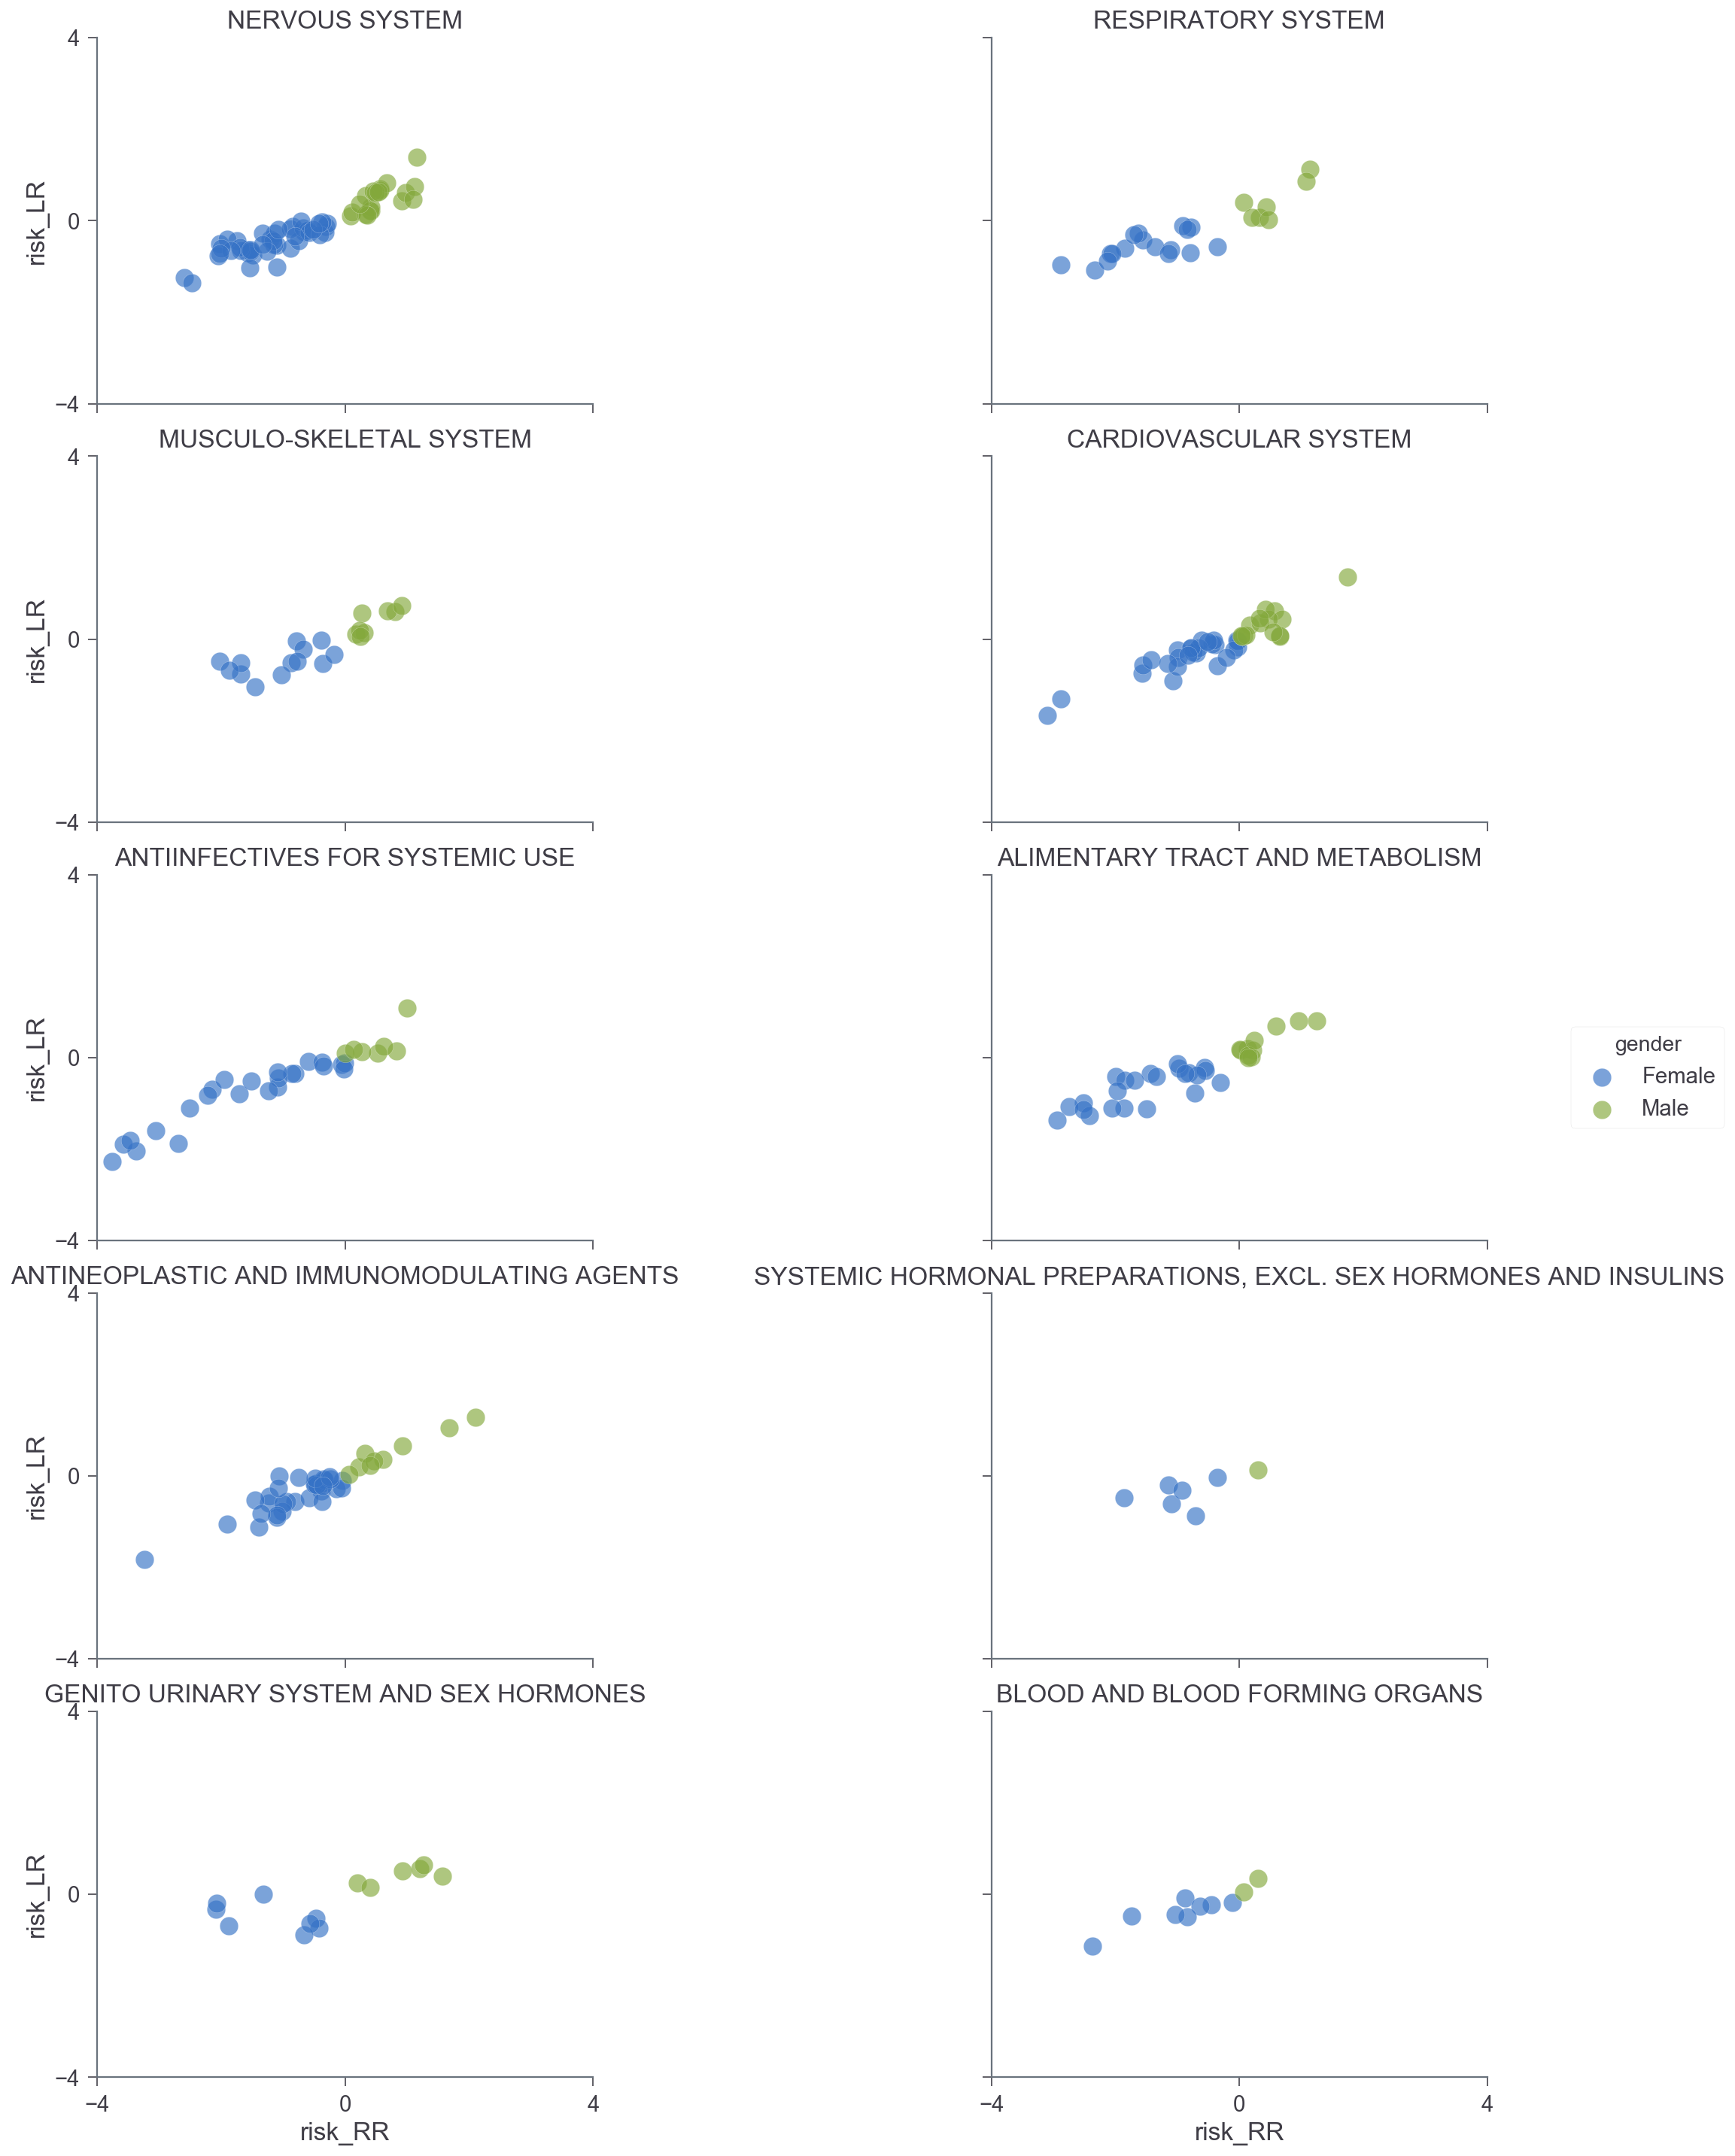

In [22]:
#seaborn riskLR vs riskRR for different ATC 1 classes 

plot = assignATC(df_drugRisks_sig, ATC_level=1)
plot = plot[plot['ATC_1_name'].isin(groupbyATC(plot, ATC_level='1', minimum_count=5).index.values)]
g = sns.FacetGrid(plot, col="ATC_1_name", hue="gender", size=4, aspect=1.75, col_wrap=2)
g = (g.map(plt.scatter, "risk_RR", "risk_LR", s=150, alpha=0.65, edgecolor="w").set_titles("{col_name}").set(xlim=(-4, 4), ylim=(-4, 4),
                xticks=[-4, 0, 4], yticks=[-4, 0, 4]).add_legend())

#### Reliability Figure Subplots

In [ ]:
# TOP VALIDATION DISTRIBUTION 
dataframe = reliability

#Max risk on top
dataframe = dataframe.reindex(dataframe.risk.abs().sort_values(ascending=True).index).reset_index()
arr_Risk = dataframe.get('risk').values

MIN = min(arr_Risk)
MAX = max(arr_Risk)

mBound = np.linspace(MIN, 0, 100)
fBound = np.linspace(0, MAX, 100)
norm = mpt.colors.BoundaryNorm(
    boundaries=np.concatenate([mBound, fBound]), ncolors=256)
color_obj = mpt.cm.ScalarMappable(norm=norm, cmap='RdBu')
color_obj.set_array(arr_Risk)
colors = color_obj.to_rgba(arr_Risk)

fig, ax = plt.subplots(1, 1, figsize=(14, 8))


for i, row in dataframe.iterrows():
    
    if (row.drug_concept_name in yes_drugs):
        marker='D'
        markersize=12
        alpha=0
        color=GREEN
    elif (row.drug_concept_name in no_drugs):
        marker='D'
        markersize=12
        alpha=0
        color=YELLOW
    else:
        marker='o'
        markersize=9
        alpha=0.7
        if (row.risk>0):
            color = LIGHT_BLUE
        else:
            color = LIGHT_RED
        
    ax.plot(
        'sample_size',
        'outcome_count',
        data=row,
        color=color,
        marker=marker,
        markersize=markersize,
        alpha=alpha,
        markeredgecolor='k',
        markeredgewidth=1)
    
for i, row in dataframe.iterrows():
    
    if (row.drug_concept_name in yes_drugs):
        marker='D'
        markersize=12
        alpha=1
        color=GREEN
    elif (row.drug_concept_name in no_drugs):
        marker='D'
        markersize=12
        alpha=1
        color=YELLOW
    else:
        marker='o'
        markersize=9
        alpha=0
        if (row.risk>0):
            color = LIGHT_BLUE
        else:
            color = LIGHT_RED     
        
    ax.plot(
        'sample_size',
        'outcome_count',
        data=row,
        color=color,
        marker=marker,
        markersize=markersize,
        alpha=alpha,
        markeredgecolor='k',
        markeredgewidth=1)

ax.axhline(0, alpha=0.9, color='k')
ax.axvline(0, alpha=0.9, color='k')


ax.tick_params('both',color='white')
ax.set_xticklabels(labels=[0, 0, 500, 1000, 1500, 2000, 2500], fontsize=14)
ax.set_yticklabels(labels=[0, 0, 20, 40, 60, 80, 100, 120, 140, 160], fontsize=14)

#ax.set_xlabel('     Sample Size', fontsize=16, labelpad=15)
#ax.set_ylabel('Outcome Count', fontsize=16, labelpad=15)

#ax.set_title("        Reliability of Drug Risks", fontsize=20, pad=28)


ax.grid(alpha=0.4)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

legend_markersize = 10
green = mpt.lines.Line2D(
    [], [],
    linewidth=0,
    label='Consistent with Literature',
    marker='D',
    markersize=legend_markersize,
    color=GREEN,
    markeredgecolor='k',
    markeredgewidth=1)
yellow = mpt.lines.Line2D(
    [], [],
    linewidth=0,
    label='Conflicting with Literature',
    marker='D',
    markersize=legend_markersize,
    color=YELLOW,
    markeredgecolor='k',
    markeredgewidth=1)
blue = mpt.lines.Line2D(
    [], [],
    linewidth=0,
    label='Male Risk',
    marker='o',
    markersize=legend_markersize,
    color=LIGHT_BLUE,
    markeredgecolor='k',
    markeredgewidth=1)
red = mpt.lines.Line2D(
    [], [],
    linewidth=0,
    label='Female Risk',
    marker='o',
    markersize=legend_markersize,
    color=LIGHT_RED,
    markeredgecolor='k',
    markeredgewidth=1)
ax.legend(handles=[red, blue, green, yellow], loc='upper left', fontsize=12, bbox_to_anchor=[.055, 0.95])

#plt.colorbar(color_obj, orientation='vertical',  fraction=0.018, aspect=40, shrink=0.75, ticks=[MIN, 0, MAX])
plt.show( )

In [ ]:
# TOP SMALLER 
smaller = reliability.query('sample_size<500 and outcome_count<40')


dataframe = smaller
dataframe = dataframe.reindex(dataframe.risk.abs().sort_values(ascending=True).index).reset_index()
arr_Risk = dataframe.get('risk').values

MIN = min(arr_Risk)
MAX = max(arr_Risk)

mBound = np.linspace(MIN, 0, 100)
fBound = np.linspace(0, MAX, 100)
norm = mpt.colors.BoundaryNorm(
    boundaries=np.concatenate([mBound, fBound]), ncolors=256)
color_obj = mpt.cm.ScalarMappable(norm=norm, cmap='RdBu')
color_obj.set_array(arr_Risk)
colors = color_obj.to_rgba(arr_Risk)

fig, ax = plt.subplots(1, 1, figsize=(14, 8))


for i, row in dataframe.iterrows():
    
    if (row.drug_concept_name in yes_drugs):
        marker='D'
        markersize=12
        alpha=0
        color='green'
    elif (row.drug_concept_name in no_drugs):
        marker='D'
        markersize=12
        alpha=0
        color='yellow'
    else:
        marker='o'
        markersize=9
        alpha=0.7
        if (row.risk>0):
            color = LIGHT_BLUE
        else:
            color = LIGHT_RED      
        
    ax.plot(
        'sample_size',
        'outcome_count',
        data=row,
        color=color,
        marker=marker,
        markersize=markersize,
        alpha=alpha,
        markeredgecolor='k',
        markeredgewidth=1)
    
for i, row in dataframe.iterrows():
    
    if (row.drug_concept_name in yes_drugs):
        marker='D'
        markersize=12
        alpha=1
        color=GREEN#1ddb50'
    elif (row.drug_concept_name in no_drugs):
        marker='D'
        markersize=12
        alpha=1
        color=YELLOW
    else:
        marker='o'
        markersize=9
        alpha=0
        if (row.risk>0):
            color = LIGHT_BLUE
        else:
            color = LIGHT_RED     
        
    ax.plot(
        'sample_size',
        'outcome_count',
        data=row,
        color=color,
        marker=marker,
        markersize=markersize,
        alpha=alpha,
        markeredgecolor='k',
        markeredgewidth=1)

ax.set_ylim(0,40)
ax.set_xlim(0,500)

#ax.set_xlabel('     Sample Size', fontsize=16, labelpad=15)
#ax.set_ylabel('Outcome Count', fontsize=16, labelpad=15)
#ax.set_title("        Reliability of Drug Risks", fontsize=20, pad=28)

ax.tick_params('both',color='white')
ax.set_xticklabels(labels=[0, 100, 200, 300, 400, 500], fontsize=14)
ax.set_yticklabels(labels=[0, '', 10,'', 20,'', 30,'', 40], fontsize=14)

width=3
ax.axhline(0, alpha=0.9, color='k', lw=width)
ax.axvline(0, alpha=0.9, color='k', lw=width)
ax.axhline(40, alpha=0.9, color='k', lw=width)
ax.axvline(500, alpha=0.9, color='k', lw=width)

ax.grid(alpha=0.4)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)


#plt.colorbar(color_obj, orientation='vertical',  fraction=0.018, aspect=40, shrink=0.75, ticks=[MIN, 0, MAX])
plt.show()

In [ ]:
# TOP LEGEND 

green = mpt.lines.Line2D(
    [], [],
    linewidth=0,
    label='Consistent with Literature',
    marker='D',
    markersize=12,
    color=GREEN,
    markeredgecolor='k',
    markeredgewidth=1)
yellow = mpt.lines.Line2D(
    [], [],
    linewidth=0,
    label='Conflicting with Literature',
    marker='D',
    markersize=12,
    color=YELLOW,
    markeredgecolor='k',
    markeredgewidth=1)
blue = mpt.lines.Line2D(
    [], [],
    linewidth=0,
    label='Male Risk',
    marker='o',
    markersize=12,
    color=LIGHT_BLUE,
    markeredgecolor='k',
    markeredgewidth=1)
red = mpt.lines.Line2D(
    [], [],
    linewidth=0,
    label='Female Risk',
    marker='o',
    markersize=12,
    color=LIGHT_RED,
    markeredgecolor='k',
    markeredgewidth=1)

plt.legend(handles=[red, blue, green, yellow])
plt.show()

In [ ]:
# BOTTOM MALE/FEMALE SUBPLOTS 
dataframe = reliability

#Max risk on top
dataframe = dataframe.reindex(
    dataframe.risk.abs().sort_values(ascending=True).index).reset_index()
arr_Risk = dataframe.get('risk').values

MIN = min(arr_Risk)
MAX = max(arr_Risk)

mBound = np.linspace(MIN, 0, 100)
fBound = np.linspace(0, MAX, 100)
norm = mpt.colors.BoundaryNorm(
    boundaries=np.concatenate([mBound, fBound]), ncolors=256)
color_obj = mpt.cm.ScalarMappable(norm=norm, cmap='RdBu')
color_obj.set_array(arr_Risk)
colors = color_obj.to_rgba(arr_Risk)

fig, ax_obj = plt.subplots(1, 2, figsize=(14, 8), sharey=True)

for i, row in dataframe.iterrows():

    marker = 'o'
    markersize = 9
    alpha = 0.7
    color = colors[i]

    if (row.risk < 0):
        ax = ax_obj[0]
    else:
        ax = ax_obj[1]

    ax.plot(
        'sample_size',
        'outcome_count',
        data=row,
        color=color,
        marker=marker,
        markersize=markersize,
        alpha=alpha,
        markeredgecolor='k',
        markeredgewidth=1)

#ax.set_xticklabels(labels=[0, 0, 500, 1000, 1500, 2000, 2500], fontsize=14)
#ax.set_yticklabels(labels=[0, 0, 20, 40, 60, 80, 100, 120, 140, 160], fontsize=14)

ax_obj[1].set_ylim(ax_obj[0].get_ylim())

for ax in ax_obj:
    
    ax.axhline(0, alpha=0.9, color='k')
    ax.axvline(0, alpha=0.9, color='k')
    
    ax.tick_params('both', color='white')
    
    ax.grid(alpha=0.4)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

#plt.suptitle('Novel Risk Findings Suggest Females at Greater Danger for ADRs than Males',y = 0.94, horizontalalignment = 'center', fontsize=18)    
plt.subplots_adjust(wspace=0, hspace=0)
plt.colorbar(
    color_obj,
    orientation='vertical',
    fraction=0.018,
    aspect=40,
    shrink=0.75,
    pad=0,
    ticks=[round(x, 1) for x in [MIN, -5, 0, MAX]])\
    .set_label(
        'Risk Magnitude',
        rotation=270,
        horizontalalignment='center',
        labelpad=20,
        fontsize=14)
plt.show()

In [ ]:
# BOTTOM MALE SMALLER 
dataframe = reliability

#Max risk on top
dataframe = dataframe.reindex(
    dataframe.risk.abs().sort_values(ascending=True).index).reset_index()
arr_Risk = dataframe.get('risk').values

MIN = min(arr_Risk)
MAX = max(arr_Risk)

mBound = np.linspace(MIN, 0, 100)
fBound = np.linspace(0, MAX, 100)
norm = mpt.colors.BoundaryNorm(
    boundaries=np.concatenate([mBound, fBound]), ncolors=256)
color_obj = mpt.cm.ScalarMappable(norm=norm, cmap='RdBu')
color_obj.set_array(arr_Risk)
colors = color_obj.to_rgba(arr_Risk)

fig, ax = plt.subplots(1, 1, figsize=(7, 8))

for i, row in dataframe.iterrows():

    marker = 'o'
    markersize = 9
    alpha = 0.7
    color = colors[i]

    if (row.risk > 0):
        ax.plot(
            'sample_size',
            'outcome_count',
            data=row,
            color=color,
            marker=marker,
            markersize=markersize,
            alpha=alpha,
            markeredgecolor='k',
            markeredgewidth=1)

ax.set_ylim(0,25)
ax.set_xlim(0,500)

ax.tick_params('both', color='white')
ax.set_xticklabels(labels=['', 100, 200, 300, 400, 500], fontsize=14)
ax.set_yticklabels(labels=[0,5, 10, 15, 20, 25], fontsize=14)

ax.axhline(0, alpha=0.9, color='k')
ax.axvline(0, alpha=0.9, color='k')

width=2
ax.axhline(0, alpha=0.9, color='k', lw=width)
ax.axvline(0, alpha=0.9, color='k', lw=width)
ax.axhline(25, alpha=0.9, color='k', lw=width)
ax.axvline(500, alpha=0.9, color='k', lw=width)

ax.grid(alpha=0.4)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

#plt.colorbar(color_obj, orientation='vertical',  fraction=0.018, aspect=40, shrink=0.75, ticks=[MIN, 0, MAX])
plt.show()

In [ ]:
# NOT USED ~ TOP VALIDATION DISTRIBUTION COLORED BY RISK 
dataframe = reliability

#Max risk on top
dataframe = dataframe.reindex(dataframe.risk.abs().sort_values(ascending=True).index).reset_index()
arr_Risk = dataframe.get('risk').values

MIN = min(arr_Risk)
MAX = max(arr_Risk)

mBound = np.linspace(MIN, 0, 100)
fBound = np.linspace(0, MAX, 100)
norm = mpt.colors.BoundaryNorm(
    boundaries=np.concatenate([mBound, fBound]), ncolors=256)
color_obj = mpt.cm.ScalarMappable(norm=norm, cmap='RdBu')
color_obj.set_array(arr_Risk)
colors = color_obj.to_rgba(arr_Risk)

fig, ax = plt.subplots(1, 1, figsize=(14, 8))


for i, row in dataframe.iterrows():
    
    if (row.drug_concept_name in yes_drugs):
        marker='D'
        markersize=12
        alpha=0
        color=GREEN
    elif (row.drug_concept_name in no_drugs):
        marker='D'
        markersize=12
        alpha=0
        color=YELLOW
    else:
        marker='o'
        markersize=9
        alpha=0.7
        color=colors[i]      
        
    ax.plot(
        'sample_size',
        'outcome_count',
        data=row,
        color=color,
        marker=marker,
        markersize=markersize,
        alpha=alpha,
        markeredgecolor='k',
        markeredgewidth=1)
    
for i, row in dataframe.iterrows():
    
    if (row.drug_concept_name in yes_drugs):
        marker='D'
        markersize=12
        alpha=1
        color=GREEN
    elif (row.drug_concept_name in no_drugs):
        marker='D'
        markersize=12
        alpha=1
        color=YELLOW
    else:
        marker='o'
        markersize=9
        alpha=0
        color=colors[i]      
        
    ax.plot(
        'sample_size',
        'outcome_count',
        data=row,
        color=color,
        marker=marker,
        markersize=markersize,
        alpha=alpha,
        markeredgecolor='k',
        markeredgewidth=1)

ax.axhline(0, alpha=0.9, color='k')
ax.axvline(0, alpha=0.9, color='k')

ax.tick_params('both',color='white')
ax.set_xticklabels(labels=[0, 0, 500, 1000, 1500, 2000, 2500], fontsize=14)
ax.set_yticklabels(labels=[0, 0, 20, 40, 60, 80, 100, 120, 140, 160], fontsize=14)

#ax.set_xlabel('     Sample Size', fontsize=16, labelpad=15)
#ax.set_ylabel('Outcome Count', fontsize=16, labelpad=15)

#ax.set_title("        Reliability of Drug Risks", fontsize=20, pad=28)

ax.grid(alpha=0.4)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.colorbar(color_obj, orientation='vertical',  fraction=0.018, aspect=40, shrink=0.75, ticks=[MIN, 0, MAX])
plt.show( )

In [ ]:
# NOT USED ~ TOP SMALLER COLORED BY RISK 
smaller = reliability.query('sample_size<500 and outcome_count<50')


dataframe = smaller
dataframe = dataframe.reindex(dataframe.risk.abs().sort_values(ascending=True).index).reset_index()
arr_Risk = dataframe.get('risk').values

MIN = min(arr_Risk)
MAX = max(arr_Risk)

mBound = np.linspace(MIN, 0, 100)
fBound = np.linspace(0, MAX, 100)
norm = mpt.colors.BoundaryNorm(
    boundaries=np.concatenate([mBound, fBound]), ncolors=256)
color_obj = mpt.cm.ScalarMappable(norm=norm, cmap='RdBu')
color_obj.set_array(arr_Risk)
colors = color_obj.to_rgba(arr_Risk)

fig, ax = plt.subplots(1, 1, figsize=(14, 8))


for i, row in dataframe.iterrows():
    ax.plot(
        'sample_size',
        'outcome_count',
        data=row,
        color=colors[i],
        marker='o',
        markersize=10,
        alpha=0.7,
        markeredgecolor='k',
        markeredgewidth=1)

ax.axhline(0, alpha=0.9, color='k')
ax.axvline(0, alpha=0.9, color='k')
#ax.legend(loc='upper left', fontsize=25, bbox_to_anchor=[.1, 0.9])
ax.set_xlabel('     Sample Size', fontsize=16, labelpad=15)
ax.set_ylabel('Outcome Count', fontsize=16, labelpad=15)
ax.set_title("        Reliability of Drug Risks", fontsize=20, pad=28)
ax.grid(alpha=0.4)

ax.set_xticklabels(labels=[0, 0, 100, 200, 300, 400, 500], fontsize=14)
ax.set_yticklabels(labels=[0, 0, 10, 20, 30, 40, 50], fontsize=14)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.tick_params('both',color='white')

plt.colorbar(color_obj, orientation='vertical',  fraction=0.018, aspect=40, shrink=0.75, ticks=[MIN, 0, MAX])
plt.show()

#### ATC Barplot

In [55]:
aeolus_IDNAME = pd.read_feather(ROOT + "AEOLUS/drugIDdrugName_unique.feather")

def plotATC(df, ATC_level="3"):
    if (type(ATC_level)!=str):
        ATC_level = str(ATC_level)
        
    ATC_col = "ATC_" + ATC_level + "_name"
    title = "Drugs grouped by ATC " + ATC_level + " Class"
    
    if('drug_concept_name'not in df.columns):
        if(df.index.name=='drug_concept_name'):
            df=df.reset_index()
    
    if('gender'not in df.columns):
        df=assignGender(df, by='LRn')
    
    plot = groupbyATC(df, ATC_level=ATC_level, secondary='gender', minimum_count=3).reset_index()
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    if (len(df.query('gender=="Male"'))>len(df.query('gender=="Female"'))):
        colors=[MEDIUM_BLUE, MEDIUM_PINK]
    else:
        colors=[MEDIUM_PINK, MEDIUM_BLUE]
    ax = sns.barplot(
        x='count',
        y=ATC_col,
        data=plot,
        hue='gender',
        palette=colors)
    ax.legend(loc='lower right')
    ax.set_xlabel('Number of Drugs', fontsize=15)
    ax.set_ylabel('', fontsize=15)
    ax.set_title(title, fontsize=18)
    ax.tick_params('both',color='white')
    plt.show()

def plotATC_total(df, ATC_level = 3):
    ATC_name = 'ATC_' + str(ATC_level) + '_name'
    title = "Drugs grouped by ATC " + str(ATC_level) + " Class"
    ATC_total = assignATC(
        aeolus_IDNAME,
        ATC_level=ATC_level).groupby(ATC_name).count().loc[:, ['drug_concept_id']].rename(
            columns={'drug_concept_id': 'Count'})
    ATC_plot = pd.DataFrame(
        data=groupbyATC(
            df,
            ATC_level=ATC_level,
            secondary='gender',
            minimum_count=3).unstack(level=1, fill_value=0).reset_index().values,
        columns=[ATC_name, 'Female', 'Male']).set_index(ATC_name)

    for ATC_group, row in ATC_plot.iterrows():
        ATC_plot.at[ATC_group, 'Total'] = ATC_total.at[ATC_group, 'Count']

    ATC_plot = ATC_plot.reset_index()

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)

    ax = sns.barplot(
            x='Total',
            y=ATC_name,
            data=ATC_plot,
            color=GREY)
    ax = sns.barplot(
            x='Female',
            y=ATC_name,
            data=ATC_plot,
            color=MEDIUM_PINK)
    ax = sns.barplot(
            x='Male',
            y=ATC_name,
            data=ATC_plot,
            color=MEDIUM_BLUE)

    ax.set_xlabel('Number of Drugs', fontsize=15)
    ax.set_ylabel('', fontsize=15)
    ax.tick_params('both',color='white')
    ax.set_title(title, fontsize=18)

    plt.show()
    
def plotATC_percentage(df, ATC_level=3):
 
    ATC_name = 'ATC_' + str(ATC_level) + '_name'
    ATC_total = assignATC(
        aeolus_IDNAME, ATC_level=ATC_level).groupby(
            ATC_name).count().loc[:, ['drug_concept_id']].rename(
                columns={'drug_concept_id': 'Count'})
    ATC_plot = pd.DataFrame(
        data=groupbyATC(
            df, ATC_level=ATC_level,
            secondary='gender', minimum_count=3).unstack(
                level=1, fill_value=0).reset_index().values,
        columns=[ATC_name, 'Female', 'Male']).set_index(ATC_name)

    for ATC_group, row in ATC_plot.iterrows():
        ATC_plot.at[ATC_group, 'Total'] = ATC_total.at[ATC_group, 'Count']

    ATC_plot = ATC_plot.reset_index()
    ATC_plot['Female'] = pd.to_numeric(ATC_plot['Female'])
    ATC_plot['Male'] = pd.to_numeric(ATC_plot['Male'])
    ATC_plot = ATC_plot.eval('Female = (Female/Total)*100')\
                       .eval('Male = (Male/Total)*100')\
                       .melt(id_vars=[ATC_name],
                                value_vars=['Female', 'Male'],
                                var_name='gender',
                                value_name='percentage')\
                        .sort_values(by=[ATC_name, 'gender'])
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    colors = [MEDIUM_PINK, MEDIUM_BLUE]
    ax = sns.barplot(
        x='percentage',
        y=ATC_name,
        data=ATC_plot,
        hue='gender',
        palette=colors)
    ax.legend(loc='upper right')
    ax.set_xlabel('Percentage of Drugs Showing Sex-Risk', fontsize=15)
    ax.set_ylabel('', fontsize=15)

    title = ""#"Drugs grouped by ATC " + str(ATC_level) + " Class"
    ax.set_title(title, fontsize=18)
    plt.show()
    return ATC_plot

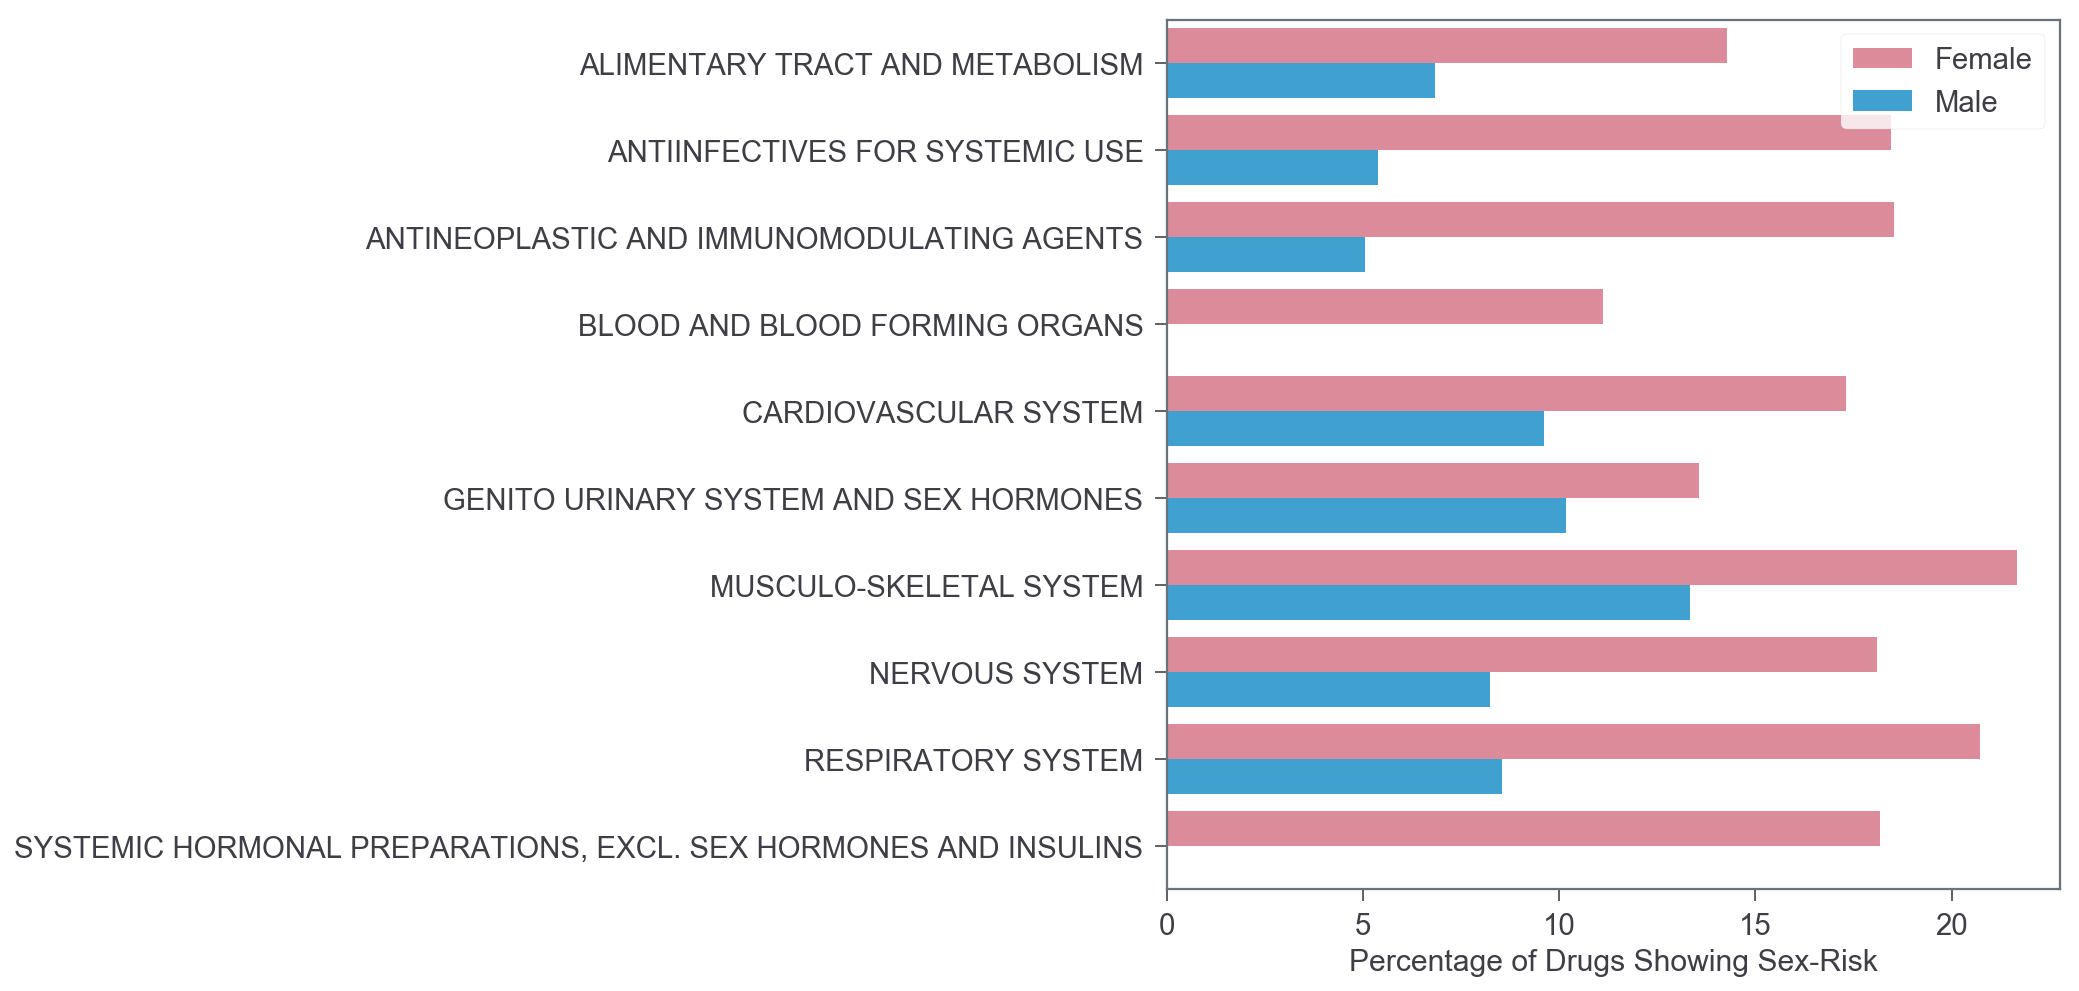

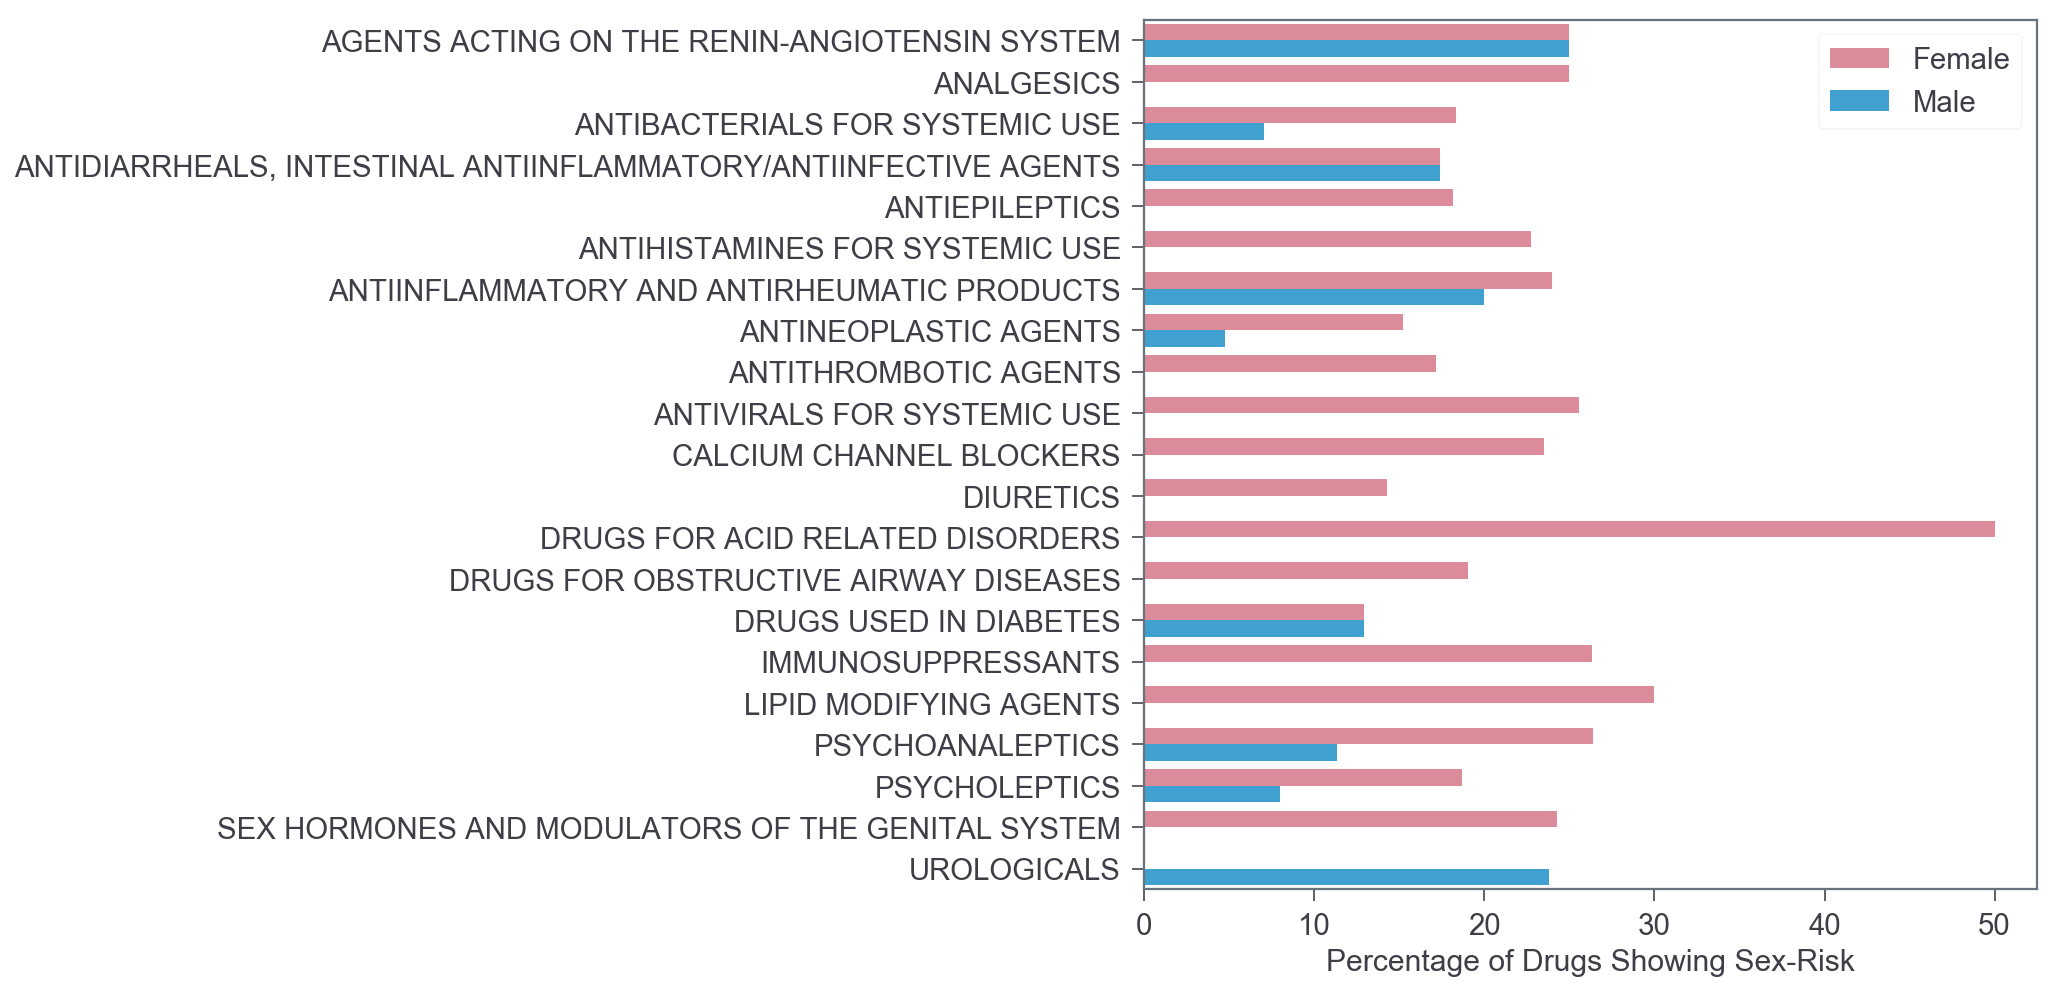

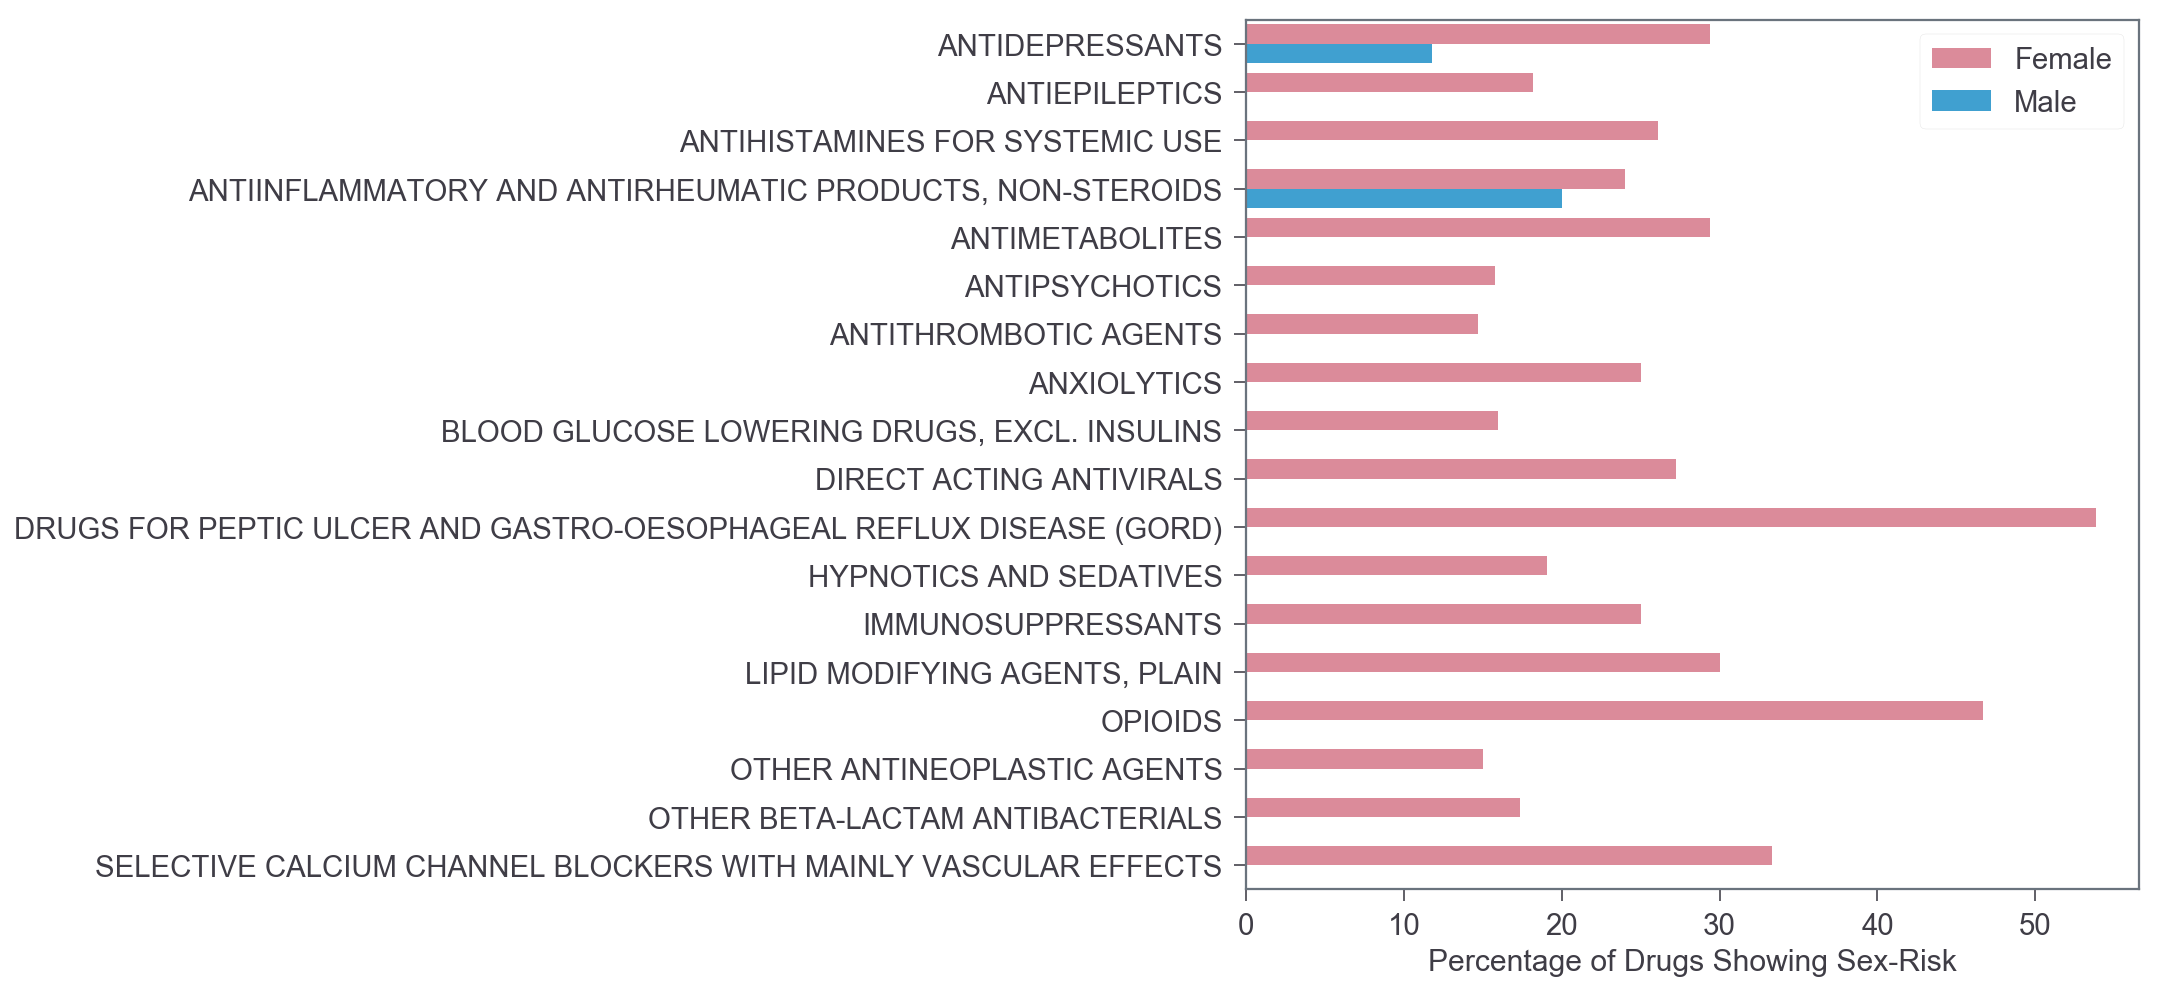

In [56]:
for level in [1, 2, 3]:
    #plotATC(df_drugRisks_sig,ATC_level=level)
    #plotATC_total(df_drugRisks_sig,ATC_level=level)
    plotATC_percentage(df_drugRisks_sig,ATC_level=level)

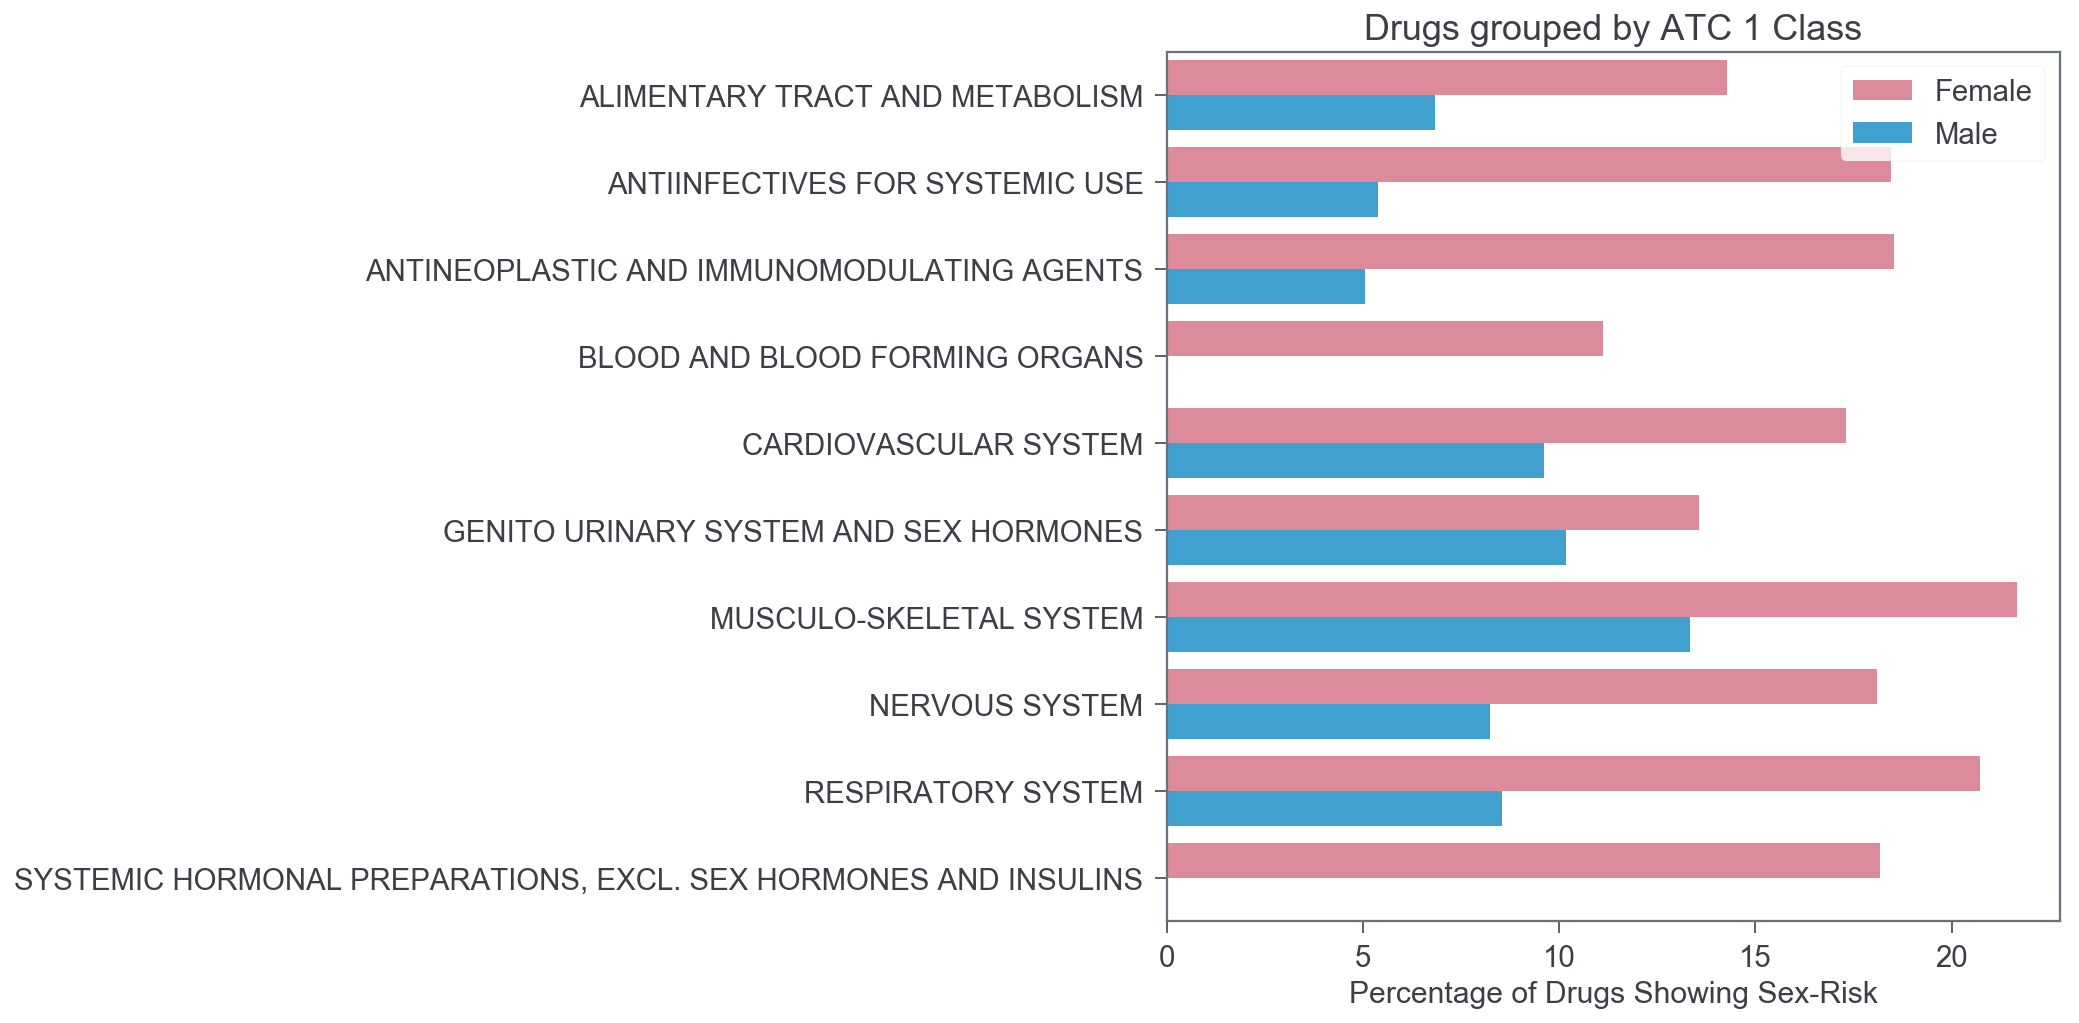

,ATC_1_name,gender,percentage
0,ALIMENTARY TRACT AND METABOLISM,Female,14.285714
10,ALIMENTARY TRACT AND METABOLISM,Male,6.832298
1,ANTIINFECTIVES FOR SYSTEMIC USE,Female,18.461538
11,ANTIINFECTIVES FOR SYSTEMIC USE,Male,5.384615
2,ANTINEOPLASTIC AND IMMUNOMODULATING AGENTS,Female,18.539326
12,ANTINEOPLASTIC AND IMMUNOMODULATING AGENTS,Male,5.056180
3,BLOOD AND BLOOD FORMING ORGANS,Female,11.111111
13,BLOOD AND BLOOD FORMING ORGANS,Male,0.000000
4,CARDIOVASCULAR SYSTEM,Female,17.307692
14,CARDIOVASCULAR SYSTEM,Male,9.615385


In [53]:
plotATC_percentage(df_drugRisks_sig,ATC_level=1)

#### Network

In [ ]:
allDrugs = assignATC(df_drugRisks_sig)

In [ ]:
for drug in allDrugs.query('ATC_3_name=="ANTIDEPRESSANTS"').index:
    df_genderAsso_sig.query('drug_concept_name==@drug')\
                    .melt(
                            id_vars=['drug_concept_name'],
                            value_vars=['outcome_concept_name'])\
                    .assign(variable='do')\
                    .rename(columns={
                                        'drug_concept_name': 'source',
                                        'variable': 'interaction',
                                        'value': 'target'})\
                    .to_excel(ROOT + '/Network/Antidepressants/' + drug + '.xlsx')

In [ ]:
i = 0
for drug in allDrugs.query('ATC_3_name=="ANTIDEPRESSANTS"').index:
    if (i == 0):
        fullData = df_genderAsso_sig.query('drug_concept_name==@drug')\
                    .loc[:, ['drug_concept_name',
                             'outcome_concept_name',
                             'outcome_rank',
                             'gender',
                             'gender_ROR_normal',
                             'gender_LR_normal',
                             'gender_RR_normal']]\
                    .assign(interaction='do')\
                    .reset_index().drop('index',1)
        unique = fullData['outcome_concept_name'] + str(i)
        fullData = fullData.assign(unique_outcome=unique)
    else:
        data = df_genderAsso_sig.query('drug_concept_name==@drug')\
                        .loc[:, ['drug_concept_name',
                             'outcome_concept_name',
                             'outcome_rank',
                             'gender',
                             'gender_ROR_normal',
                             'gender_LR_normal',
                             'gender_RR_normal']]\
                        .assign(interaction='do')\
                        .reset_index().drop('index',1)
        unique = data['outcome_concept_name'] + str(i)
        data = data.assign(unique_outcome=unique)
        fullData = fullData.append(data)

    #data.to_excel(ROOT + '/Network/Antidepressants/' + drug + '.xlsx',sheet_name="ANTIDEPRESSANTS")
    i += 1

In [ ]:
fullData = fullData.eval('avg_frequency=(gender_ROR_normal+gender_LR_normal+gender_RR_normal)/3')
fullData = fullData.loc[:, [
    'drug_concept_name',
    'interaction',
    'unique_outcome',
    'outcome_concept_name',
    'outcome_rank',
    'gender',
    'avg_frequency']]

In [ ]:
fullData.to_excel(
    ROOT + '/Network/Antidepressants/ALL.xlsx',
    sheet_name="ANTIDEPRESSANTS")

In [ ]:
anti = allDrugs.query('ATC_3_name=="ANTIDEPRESSANTS"')
anti.avg_risk = anti.avg_risk.abs()
anti.avg_risk = round(anti.avg_risk, 1)
anti.avg_risk *= anti.avg_risk*70
anti.sort_values(by='avg_risk')

### Paper –– Tables 

In [ ]:
#SUPPLEMENTARY. All Drug Risks 
#assign mean risk, reformat and make excel file from df_drugRisks_sig
df_drugRisks_sig = assignRisk(df_drugRisks_sig,columns=['risk_LRn','risk_RRn'])
df_drugRisks_sig.reset_index().rename(
    columns={
        'drug_concept_name': 'Drug Concept Name',
        'risk_ROR': 'Risk (ROR)',
        'risk_RORn': 'Risk (normalized ROR)',
        'risk_LR': 'Risk (LR)',
        'risk_LRn': 'Risk (normalized LR)',
        'risk_RR': 'Risk (RR)',
        'risk_RRn': 'Risk (normalized RR)',
        'gender': 'Gender',
        'drug_concept_id': 'Drug Concept ID',
        'avg_risk': 'Mean Risk (normalized LR and normalized RR)'
    }).loc[:, [
        'Drug Concept ID', 'Drug Concept Name', 'Gender', 'Risk (ROR)',
        'Risk (normalized ROR)', 'Risk (LR)', 'Risk (normalized LR)',
        'Risk (RR)', 'Risk (normalized RR)',
        'Mean Risk (normalized LR and normalized RR)'
    ]].to_excel(ROOT+'Tables/ALL DRUG RISKS.xlsx')

In [ ]:
#TABLE. Permutation Analysis
columns = ['All Consistent', '1/6 Conflicting', '2/6 Conflicting', '3/6 Conflicting']
data=np.array([['85%','3%','11%','0.75%'],['52%','20%','19%','9%']])
index = ['Results', 'Random']
pd.DataFrame(columns=columns, index=index, data=data).to_latex()

In [ ]:
#TABLE. Drug Literature Validation

#mention expected gender is female for all drugs

drugs = df_literature.query('validation!="Drug Not Found"').get('drug_concept_name').unique()[1:]
validationTable = pd.DataFrame(index=drugs)
validationTable.index.name='drug_concept_name'

#COPY RISK SCORES FROM DF_DRUGRISKS
validationTable.assign(risk_score=0)
for drug, row in validationTable.iterrows():
    if (len(df_drugRisks_sig.filter(regex=re.compile(drug, re.IGNORECASE),axis=0).get('avg_risk').values)>1):
        if(not df_drugRisks_sig.filter(regex=re.compile(drug, re.IGNORECASE),axis=0).index[0]==drug):
            print("Wrong Choice!!!", drug)
            print(df_drugRisks_sig.filter(regex=re.compile(drug, re.IGNORECASE),axis=0).get('avg_risk'))
    validationTable.at[drug, 'risk_score'] = round(df_drugRisks_sig.filter(regex=re.compile(drug, re.IGNORECASE),axis=0).get('avg_risk').values[0], 2)

#COPY FROM DF_LITERATURE
for drug in validationTable.index:
        for col in ['drug_class_name','expected_gender']: #validation, notes
            papers = df_literature.query('drug_concept_name==@drug')\
                    .loc[:,[col]]\
                    .drop_duplicates().get(col).values
            cite_str = ''
            for i, citation in enumerate(papers):
                cite_str += citation
                if (i+1<len(papers)):
                    cite_str += ", "
                else:
                    cite_str += ""
            validationTable.at[drug, col] = cite_str

#CITATIONS 
df_literature = df_literature.assign(citation=df_literature['paper_first_author'])
latexCitations = [['Bigos','bigos_sex_2009'],
                  ['Tran','tran_gender_1998'],
                  ['Tharpe','tharpe_adverse_2011'],
                  ['Rodenburg','rodenburg_sex_2012'],
                  ['Rademaker','rademaker_women_2001'],
                  ['Drici','drici_is_2001'],
                  ['Ofotokun','ofotokun_sex_2003'],
                  ['Whitley','whitley_sex-based_2009']]
for idx, row in df_literature.iterrows(): 
    for cite in latexCitations: 
        if (df_literature.at[idx,'citation']==cite[0]):
            df_literature.at[idx,'citation']=cite[1]
validationTable.assign(citation='unk')
for drug in validationTable.index:
    papers = df_literature.query('drug_concept_name==@drug')\
            .loc[:,['citation']]\
            .drop_duplicates().get('citation').values
    cite_str = '\cite{'
    for i, citation in enumerate(papers):
        cite_str += citation
        if (i+1<len(papers)):
            cite_str += ", "
        else:
            cite_str += "}"
    validationTable.at[drug, 'citation'] = cite_str

validationTable = validationTable.assign(literature=" ")
validationTable['literature']=validationTable['expected_gender']+validationTable['literature']+validationTable['citation']#+citation
validationTable = validationTable.drop(['expected_gender', 'citation'],1)

pd.set_option('display.max_colwidth', -1)
atc1 = [
    'Nervous System',
    'Cardiovascular System',
    'Cardiovascular System',
    'Cardiovascular System',
    'Cardiovascular System',
    'Nervous System',
    'Nervous System',
    'Cardiovascular System',
    'Antiinfectives',
    'Antiinfectives',
    'Antiinfectives',
    'Antiinfectives',
    'Nervous System']
validationTable.sort_values(by='drug_class_name')\
                .assign(atc_1=atc1).drop('drug_class_name',1)\
                .sort_values(by=['atc_1','drug_concept_name'], ascending=True)\
                .reset_index()\
                .rename(columns={"drug_concept_name":"Drug Name",'atc_1':"Drug Class", 'literature':'Risk in Literature','risk_score':'Mean Risk Score'})\
                .set_index(['Drug Class','Drug Name']).to_latex()

### Propensity Score Matching

#### Generic matrix (all data) for PSM

In [47]:
df_aeolus = pd.read_feather(ROOT + "AEOLUS/clean_withRank.tsv.feather")

In [22]:
drugs= df_aeolus.get('drug_concept_name').unique()
basic= ['Age','Sex','NumDrugs']
cols = np.append(basic,drugs)
rows = df_aeolus.get('id').unique()
df_PSM_all = pd.DataFrame(data=False,columns=cols,index=rows)
df_PSM_all.Sex = 'UNK'
df_PSM_all.Age = 0
df_PSM_all.NumDrugs = 0
df_PSM_all.index.name = 'ID'

In [26]:
for idx, data in df_aeolus.groupby(by=['id', 'master_age', 'gender_code']):
    pid = idx[0]
    df = df_PSM_all
    df.at[pid, 'Age'] = idx[1]
    df.at[pid, 'Sex'] = idx[2]
    drugs = data.get('drug_concept_name').unique()
    df.at[pid, 'NumDrugs'] = len(drugs)
    for drug in drugs:
        df.at[pid,drug]=True

In [27]:
df_PSM_all.reset_index().to_feather(ROOT+'PSM/Generic Matrix.feather')

#### Logistic Regression

In [11]:
df_aeolus = pd.read_feather(ROOT + "AEOLUS/clean_withRank.tsv.feather")
df_PSM_all = pd.read_feather(ROOT+'PSM/Generic Matrix.feather').set_index('ID')
df_PSM_all.index.name = 'ID'

##### 1% drugs -- crosscheck code on Github

In [50]:
temp = df_PSM_all.query('Sotalol==True').applymap(lambda x: 1 if x == True else x).applymap(lambda x: 0 if x == False else x).mean(axis=0).ge(0.01)

In [54]:
covariate_s1 = np.array(temp.index)[np.array(temp.values)].tolist()

In [55]:
covariate_s1.remove(drug)

In [57]:
# logistic regression 
drug='Sotalol'
y = df_PSM_all.loc[:,[drug]]
y=y.values.reshape(1,-1)[0]
X = df_PSM_all.loc[:,covariate_s1]

propensity = LogisticRegressionCV(penalty='l2')

propensity = propensity.fit(X,y)
pscore = propensity.predict_proba(X)[:,1] 
df_PSM_all['Propensity'] = pscore

#len([b for b in (np.abs(propensity.coef_[0])) if b > 0])

In [58]:
# logistic regression 
drug='Sotalol'
y = df_PSM_all.loc[:,[drug]]
y=y.values.reshape(1,-1)[0]
X = df_PSM_all.loc[:,covariate_s1]

propensity_noCV = LogisticRegression(penalty='l1')

propensity_noCV = propensity_noCV.fit(X,y)
pscore = propensity_noCV.predict_proba(X)[:,1] 
df_PSM_all['Propensity_noCV'] = pscore

#len([b for b in (np.abs(propensity.coef_[0])) if b > 0])

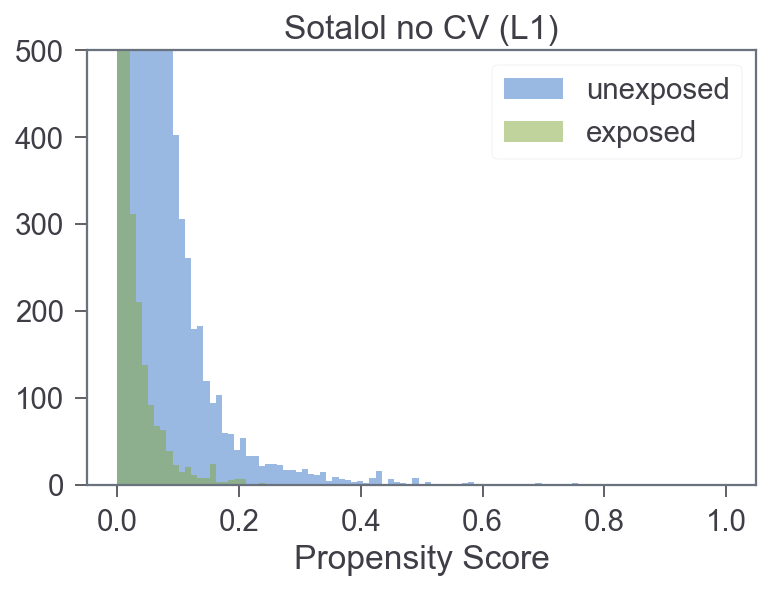

In [64]:
# hist 

drug='Sotalol'

exposed = df_PSM_all.query('{}==1'.format(drug))
unexposed = df_PSM_all.query('{}==0'.format(drug))
bins = np.linspace(0, 1, 100)

plt.hist(unexposed.Propensity_noCV, bins, alpha=0.5, label='unexposed')
plt.hist(exposed.Propensity_noCV, bins, alpha=0.5, label='exposed')
plt.ylim(0,500)
plt.title(drug+" no CV (L1)")
plt.xlabel("Propensity Score")
plt.legend(loc='upper right')
plt.show()

In [65]:

def getSensSpec(threshold): 
    drug = 'Sotalol'
    TP, FN, TN, FP = 0, 0, 0, 0
    
    for idx, data in df_PSM_all.loc[:,[drug,'Propensity']].iterrows():
        pscore = data.get('Propensity')
        drugVal = data.get(drug)
        if (drugVal):
            if(pscore>=threshold):
                TP+=1
            else:
                FN+=1
        else:
            if(pscore<=threshold):
                TN+=1
            else:
                FP+=1
    
    sens = TP/(TP+FN)
    spec = TN/(TN+FP)
    return[threshold, sens, 1-spec]

In [66]:
# QUICK ROC ~ multiprocess 

thresholds = np.linspace(0,1,11)
PROCESSES = 4
pool = multiprocessing.Pool(processes=PROCESSES)
result = pool.map(getSensSpec, thresholds)
pool.close()
names = ["Threshold", "Sensitivity", "1 - Specificity"]
ROC_result = pd.DataFrame(data=result, columns=names)

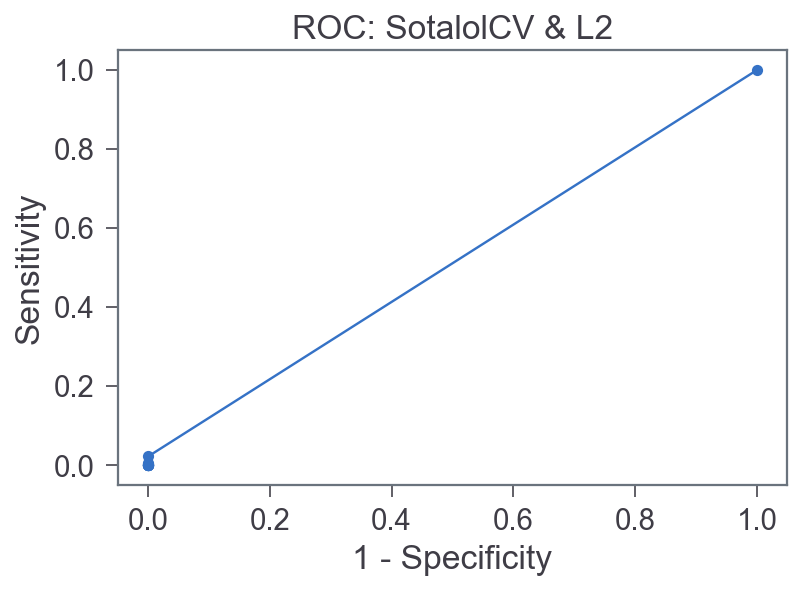

In [68]:
# PLOT ROC 

plt.plot( '1 - Specificity', 'Sensitivity', data=ROC_result, marker='o')
plt.title("ROC: "+drug+"CV & L2")
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.show()

#sns.lmplot(data=ROC_result, x='', y='', fit_reg=False,)

In [71]:

def getSensSpec(threshold): 
    drug = 'Sotalol'
    TP, FN, TN, FP = 0, 0, 0, 0
    
    for idx, data in df_PSM_all.loc[:,[drug,'Propensity_noCV']].iterrows():
        pscore = data.get('Propensity_noCV')
        drugVal = data.get(drug)
        if (drugVal):
            if(pscore>=threshold):
                TP+=1
            else:
                FN+=1
        else:
            if(pscore<=threshold):
                TN+=1
            else:
                FP+=1
    
    sens = TP/(TP+FN)
    spec = TN/(TN+FP)
    return[threshold, sens, 1-spec]

In [72]:
# QUICK ROC ~ multiprocess 

thresholds = np.linspace(0,1,11)
PROCESSES = 4
pool = multiprocessing.Pool(processes=PROCESSES)
result = pool.map(getSensSpec, thresholds)
pool.close()
names = ["Threshold", "Sensitivity", "1 - Specificity"]
ROC_result = pd.DataFrame(data=result, columns=names)

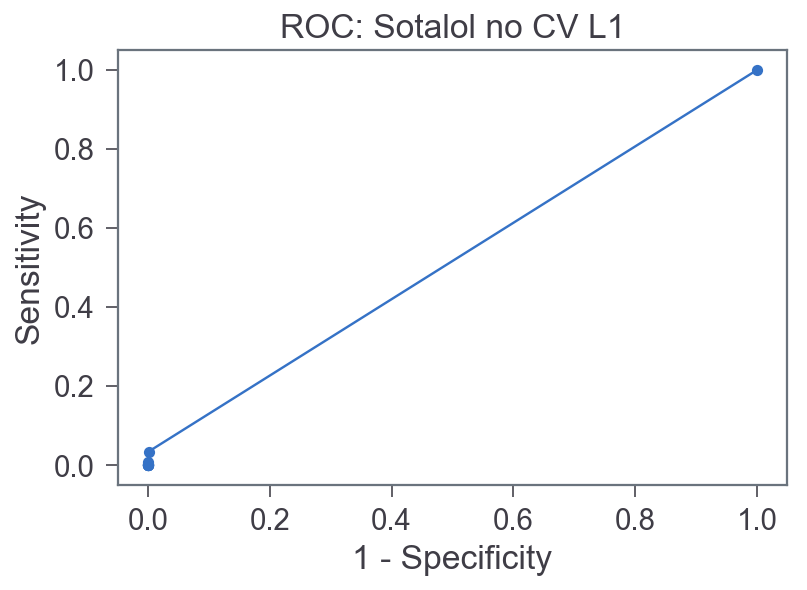

In [73]:
# PLOT ROC 

plt.plot( '1 - Specificity', 'Sensitivity', data=ROC_result, marker='o')
plt.title("ROC: "+drug+" no CV L1")
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.show()

#sns.lmplot(data=ROC_result, x='', y='', fit_reg=False,)

##### Acyclovir

In [12]:
drug = 'Acyclovir'
# ROC function 
def getSensSpec(threshold): 
    drug = 'Acyclovir'
    TP, FN, TN, FP = 0, 0, 0, 0
    
    for idx, data in df_PSM_all.loc[:,[drug,'Propensity']].iterrows():
        pscore = data.get('Propensity')
        drugVal = data.get(drug)
        if (drugVal):
            if(pscore>=threshold):
                TP+=1
            else:
                FN+=1
        else:
            if(pscore<=threshold):
                TN+=1
            else:
                FP+=1
    
    sens = TP/(TP+FN)
    spec = TN/(TN+FP)
    return[threshold, sens, 1-spec]

In [16]:
# creating drug dataframe 

PIDs_onDrug = df_PSM_all.index[df_PSM_all[drug] == True].tolist()
df_aeolus_drugPID = df_aeolus.loc[:,['drug_concept_name']]

concomitant = df_aeolus_drugPID[df_aeolus_drugPID.index.isin(PIDs_onDrug)]\
            .reset_index()\
            .drop_duplicates()\
            .query('drug_concept_name!=@drug')\
            .get('drug_concept_name')\
            .unique()

covariates = ['Age','NumDrugs']
covariates = np.append(covariates, concomitant)

NameError: name 'drug' is not defined

In [ ]:
y = df_PSM_all.loc[:,[drug]]
y=y.values.reshape(1,-1)[0]
X = df_PSM_all.loc[:,covariates]

In [ ]:
# logistic regression 
y = df_PSM_all.loc[:,[drug]]
y=y.values.reshape(1,-1)[0]
X = df_PSM_all.loc[:,covariates]

propensity = LogisticRegressionCV(penalty='l2')

propensity = propensity.fit(X,y)
pscore = propensity.predict_proba(X)[:,1] 
df_PSM_all['Propensity'] = pscore

#len([b for b in (np.abs(propensity.coef_[0])) if b > 0])

In [124]:
#print(len([b for b in (np.abs(propensity.coef_[0])) if b > 0]) , " out of" ,  len(covariates))
#np.take(covariates, np.nonzero(propensity.coef_[0])[0])

In [ ]:
# hist 

exposed = df_PSM_all.query('{}==1'.format(drug))
unexposed = df_PSM_all.query('{}==0'.format(drug))
bins = np.linspace(0, 1, 100)

plt.hist(unexposed.Propensity, bins, alpha=0.5, label='unexposed')
plt.hist(exposed.Propensity, bins, alpha=0.5, label='exposed')
plt.ylim(0,1000)
plt.title(drug+" L2")
plt.xlabel("Propensity Score")
plt.legend(loc='upper right')
plt.show()

In [128]:
# QUICK ROC ~ multiprocess 

thresholds = np.linspace(0,1,11)
PROCESSES = 4
pool = multiprocessing.Pool(processes=PROCESSES)
result = pool.map(getSensSpec, thresholds)
pool.close()
names = ["Threshold", "Sensitivity", "1 - Specificity"]
ROC_result = pd.DataFrame(data=result, columns=names)

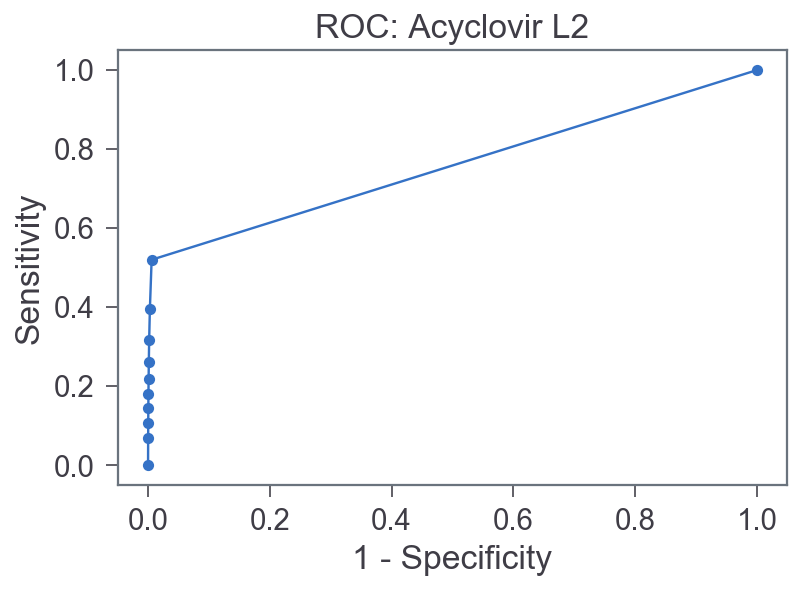

In [129]:
# PLOT ROC 

plt.plot( '1 - Specificity', 'Sensitivity', data=ROC_result, marker='o')
plt.title("ROC: "+drug+" L2")
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.show()

#sns.lmplot(data=ROC_result, x='', y='', fit_reg=False,)

##### Acetaminophen

In [18]:
drug = 'Acetaminophen' 
# ROC function 
def getSensSpec(threshold):
    drug = 'Acetaminophen'
    TP, FN, TN, FP = 0, 0, 0, 0
    
    for idx, data in df_PSM_all.loc[:,[drug,'Propensity']].iterrows():
        pscore = data.get('Propensity')
        drugVal = data.get(drug)
        if (drugVal):
            if(pscore>=threshold):
                TP+=1
            else:
                FN+=1
        else:
            if(pscore<=threshold):
                TN+=1
            else:
                FP+=1
    
    sens = TP/(TP+FN)
    spec = TN/(TN+FP)
    return[threshold, sens, 1-spec]

In [19]:
# creating drug dataframe 

PIDs_onDrug = df_PSM_all.index[df_PSM_all[drug] == True].tolist()
df_aeolus_drugPID = df_aeolus.loc[:,['drug_concept_name']]

concomitant = df_aeolus_drugPID[df_aeolus_drugPID.index.isin(PIDs_onDrug)]\
            .reset_index()\
            .drop_duplicates()\
            .query('drug_concept_name!=@drug')\
            .get('drug_concept_name')\
            .unique()

covariates = ['Age','NumDrugs']
covariates = np.append(covariates, concomitant)

In [22]:
y = df_PSM_all.loc[:,[drug]]
y=y.values.reshape(1,-1)[0]
X = df_PSM_all.loc[:,covariates]

In [ ]:
# logistic regression 
y = df_PSM_all.loc[:,[drug]]
y=y.values.reshape(1,-1)[0]
X = df_PSM_all.loc[:,covariates]


propensity = LogisticRegressionCV(penalty='l2')

propensity = propensity.fit(X,y)
pscore = propensity.predict_proba(X)[:,1] 
df_PSM_all['Propensity'] = pscore

#len([b for b in (np.abs(propensity.coef_[0])) if b > 0])

In [57]:
print(len([b for b in (np.abs(propensity.coef_[0])) if b > 0]) , " out of" ,  len(covariates))
np.take(covariates, np.nonzero(propensity.coef_[0])[0])

1044  out of 1044


array(['Age', 'NumDrugs', 'Amlodipine', ..., 'Loteprednol.Etabonate',
       'Cerivastatin.Sodium', 'Methamphetamine'], dtype=object)

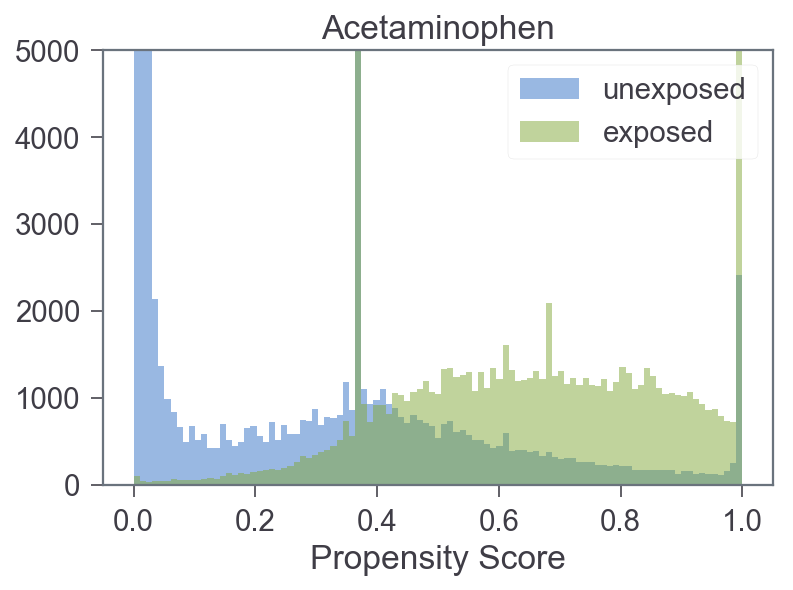

In [61]:
# hist 

exposed = df_PSM_all.query('{}==1'.format(drug))
unexposed = df_PSM_all.query('{}==0'.format(drug))
bins = np.linspace(0, 1, 100)

plt.hist(unexposed.Propensity, bins, alpha=0.5, label='unexposed')
plt.hist(exposed.Propensity, bins, alpha=0.5, label='exposed')
plt.ylim(0,5000)
plt.title(drug)
plt.xlabel("Propensity Score")
plt.legend(loc='upper right')
plt.show()

In [59]:
# QUICK ROC ~ multiprocess 

thresholds = np.linspace(0,1,11)
PROCESSES = 4
pool = multiprocessing.Pool(processes=PROCESSES)
result = pool.map(getSensSpec, thresholds)
pool.close()
names = ["Threshold", "Sensitivity", "1 - Specificity"]
ROC_result = pd.DataFrame(data=result, columns=names)

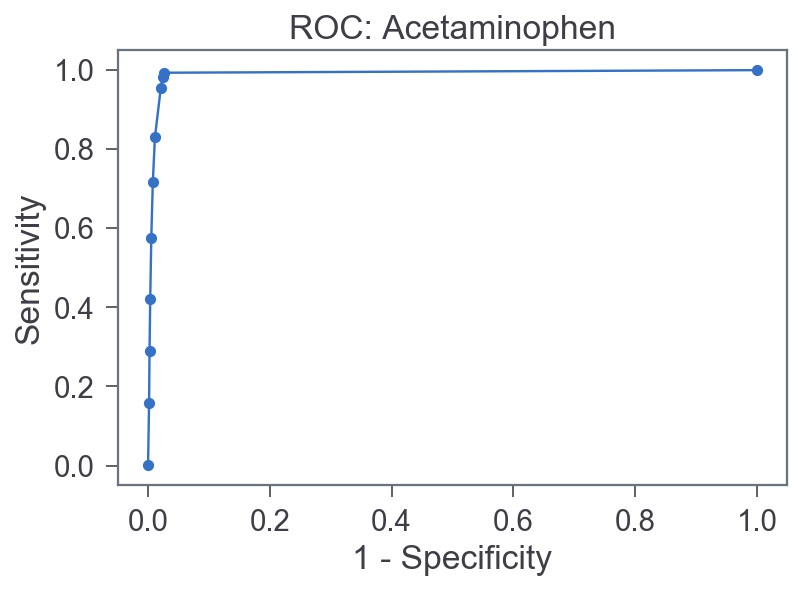

In [62]:
# PLOT ROC 

plt.plot( '1 - Specificity', 'Sensitivity', data=ROC_result, marker='o')
plt.title("ROC: "+drug)
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.show()

#sns.lmplot(data=ROC_result, x='', y='', fit_reg=False,)

##### Sotalol

In [42]:
drug = 'Sotalol'
# ROC function 
def getSensSpec(threshold):
    drug = 'Sotalol'
    TP, FN, TN, FP = 0, 0, 0, 0
    
    for idx, data in df_PSM_all.loc[:,[drug,'Propensity']].iterrows():
        pscore = data.get('Propensity')
        drugVal = data.get(drug)
        if (drugVal):
            if(pscore>=threshold):
                TP+=1
            else:
                FN+=1
        else:
            if(pscore<=threshold):
                TN+=1
            else:
                FP+=1
    
    sens = TP/(TP+FN)
    spec = TN/(TN+FP)
    return[threshold, sens, 1-spec]

In [43]:
# creating drug dataframe 

PIDs_onDrug = df_PSM_all.index[df_PSM_all[drug] == True].tolist()
df_aeolus_drugPID = df_aeolus.loc[:,['drug_concept_name']]

concomitant = df_aeolus_drugPID[df_aeolus_drugPID.index.isin(PIDs_onDrug)]\
            .reset_index()\
            .drop_duplicates()\
            .query('drug_concept_name!=@drug')\
            .get('drug_concept_name')\
            .unique()

covariates = ['Age','NumDrugs']
covariates = np.append(covariates, concomitant)

In [44]:
# logistic regression 
y = df_PSM_all.loc[:,[drug]]
y=y.values.reshape(1,-1)[0]
X = df_PSM_all.loc[:,covariates]


propensity = LogisticRegression(penalty='l1')

propensity = propensity.fit(X,y)
pscore = propensity.predict_proba(X)[:,1] 
df_PSM_all['Propensity'] = pscore

#len([b for b in (np.abs(propensity.coef_[0])) if b > 0])

In [50]:
print(len([b for b in (np.abs(propensity.coef_[0])) if b > 0]) , " out of" ,  len(covariates))
np.take(covariates, np.nonzero(propensity.coef_[0])[0])

544  out of 559


array(['Age', 'NumDrugs', 'Carboplatin', 'Trazodone', 'Stavudine',
       'Moxifloxacin', 'Sirolimus', 'Dasatinib', 'Sunitinib',
       'Gentamicin', 'Ceftazidime', 'Calcium', 'Clarithromycin',
       'Escitalopram', 'Lapatinib', 'Aripiprazole', 'Folic.Acid',
       'Olanzapine', 'Adalimumab', 'Fentanyl', 'Gabapentin', 'Metformin',
       'Ezetimibe', 'Lenalidomide', 'Hydroxyzine', 'Loratadine',
       'Alendronate', 'Verapamil', 'Oseltamivir', 'Thyroid.(Usp)',
       'Ciprofloxacin', 'Estradiol', 'Erlotinib', 'Warfarin', 'Glipizide',
       'Mirtazapine', 'Melphalan', 'Heparin', 'Cetuximab', 'Famotidine',
       'Docusate', 'Mexiletine', 'Clofarabine', 'Bendroflumethiazide',
       'Methadone', 'Linagliptin', 'Dalfampridine', 'Sildenafil',
       'Melatonin', 'Vancomycin', 'Metoprolol', 'Alfacalcidol',
       'Etodolac', 'Clonidine', 'Pantoprazole', 'Chlorpheniramine',
       'Telaprevir', 'Ranitidine', 'Prednisone', 'Nilotinib',
       'Atomoxetine', 'Atorvastatin', 'Rofecoxib', 'Saw

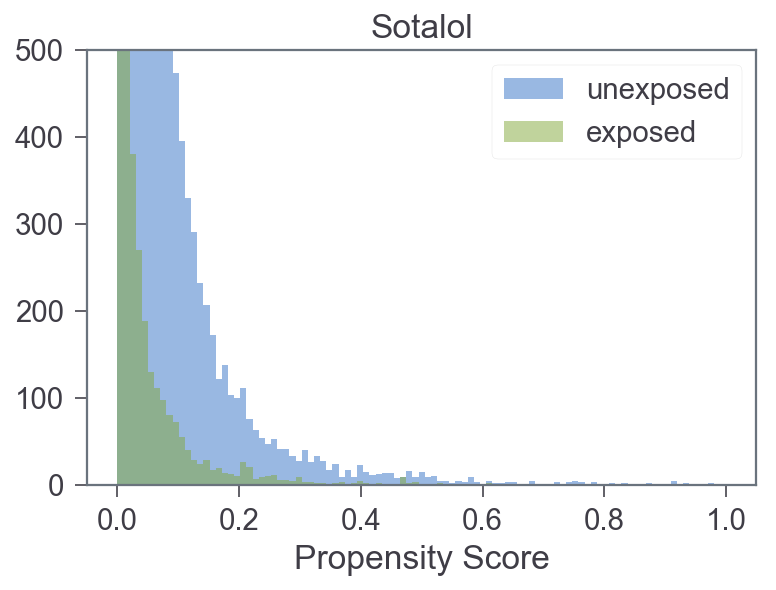

In [53]:
# hist 

exposed = df_PSM_all.query('{}==1'.format(drug))
unexposed = df_PSM_all.query('{}==0'.format(drug))
bins = np.linspace(0, 1, 100)

plt.hist(unexposed.Propensity, bins, alpha=0.5, label='unexposed')
plt.hist(exposed.Propensity, bins, alpha=0.5, label='exposed')
plt.ylim(0,500)
plt.title(drug)
plt.xlabel("Propensity Score")
plt.legend(loc='upper right')
plt.show()

In [47]:
# QUICK ROC ~ multiprocess 

thresholds = np.linspace(0,1,11)
PROCESSES = 4
pool = multiprocessing.Pool(processes=PROCESSES)
result = pool.map(getSensSpec, thresholds)
pool.close()
names = ["Threshold", "Sensitivity", "1 - Specificity"]
ROC_result = pd.DataFrame(data=result, columns=names)

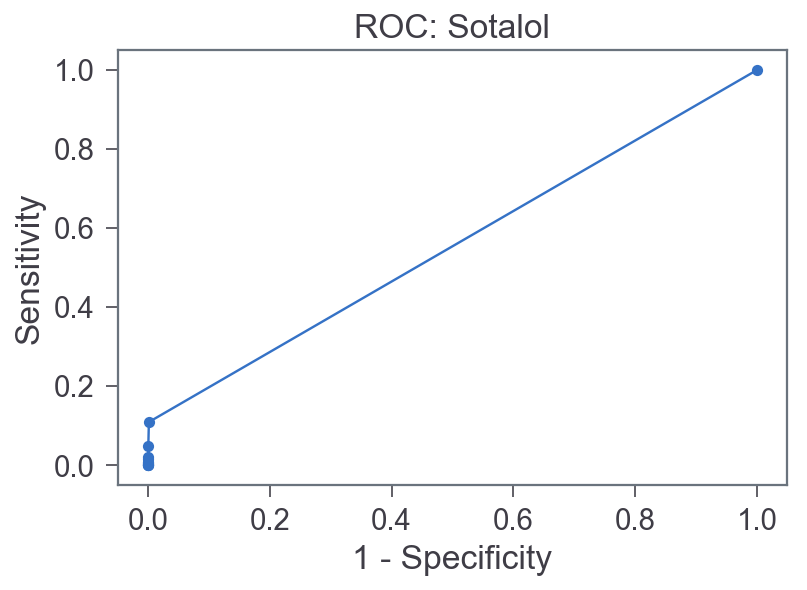

In [51]:
# PLOT ROC 

plt.plot( '1 - Specificity', 'Sensitivity', data=ROC_result, marker='o')
plt.title("ROC: "+drug)
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.show()

#sns.lmplot(data=ROC_result, x='', y='', fit_reg=False,)

##### ROC Generic

In [21]:
# ROC function 
def getSensSpec(threshold):
    
    TP, FN, TN, FP = 0, 0, 0, 0
    
    for idx, data in df_PSM_all.loc[:,[drug,'Propensity']].iterrows():
        pscore = data.get('Propensity')
        drugVal = data.get(drug)
        if (drugVal):
            if(pscore>=threshold):
                TP+=1
            else:
                FN+=1
        else:
            if(pscore<=threshold):
                TN+=1
            else:
                FP+=1
    
    sens = TP/(TP+FN)
    spec = TN/(TN+FP)
    return[threshold, sens, 1-spec]

In [ ]:
# SLOW ROC 

thresholds = np.linspace(0,1,11)
ROC_results = np.zeros((0,3))
for T in thresholds:
    T_result = getSensSpec(T, drug, df_PSM_all)
    ROC_result = np.append(ROC_results,[T_result],axis=0)

In [ ]:
# QUICK ROC ~ multiprocess 

thresholds = np.linspace(0,1,21)
PROCESSES = 16
pool = multiprocessing.Pool(processes=PROCESSES)
result = pool.map(getSensSpec, thresholds)
pool.close()
names = ["Threshold", "Sensitivity", "1 - Specificity"]
ROC_result = pd.DataFrame(data=result, columns=names)

In [ ]:
# PLOT ROC 

plt.plot( '1 - Specificity', 'Sensitivity', data=ROC_result, marker='o')
plt.title("ROC: "+title)
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.show()

#sns.lmplot(data=ROC_result, x='', y='', fit_reg=False,)

##### Cross Validation

In [ ]:
k=10 #standard
from sklearn.model_selection import KFold
?KFold

In [ ]:
kfold = KFold(k)

In [ ]:
print(b.index) for b in (np.abs(propensity.coef_[0])) if b > 0

In [130]:
pkl_filename = ROOT+"PSM/Models/Acyclovir_L2_noCV.pkl" 
with open(pkl_filename, 'wb') as file:  
    pickle.dump(propensity, file)

In [12]:
pkl_filename = ROOT+"PSM/Models/Acyclovir_L2_noCV.pkl" 

with open(pkl_filename, 'rb') as file:  
    pickle_Acet = pickle.load(file)

In [ ]:
pscore = pickle_Acet.predict_proba(X)[:,1] 
df_PSM_all['Propensity'] = pscore

In [ ]:
from sklearn.metrics import roc_auc_score
y_true = (df_PSM_all.get(drug)>0).astype(np.int8).values
y_scores = (df_PSM_all.get('Propensity')>0).astype(np.int8).values
roc_auc_score(y_true, y_scores)



#### Random Forest

In [40]:
df_PSM_all = pd.read_feather(ROOT+'PSM/Generic Matrix.feather').set_index('ID')
df_PSM_all.index.name = 'ID'

In [41]:
drug='Acetaminophen'

In [42]:
cases = df_PSM_all.query('{}==1'.format(drug))
controls = df_PSM_all.query('{}==0'.format(drug))

In [43]:
covariates = (cases>0).astype(np.int8).mean(axis=0).ge(0.01)
covariates = np.array(covariates.index)[np.array(covariates.values)].tolist()
covariates.remove(drug)
covariates.remove('Sex')

In [44]:
y = df_PSM_all.loc[:,[drug]]
y=y.values.reshape(1,-1)[0]
X = df_PSM_all.loc[:,covariates]

In [130]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, oob_score=True)

In [131]:
propensity_rf = rf.fit(X,y)

In [153]:
propensity_rf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [159]:
from sklearn.externals import joblib
filename = "{}/RF_100_none.sav".format(drug)
joblib.dump(propensity_rf, filename)

['Acetaminophen/RF_100_none.sav']

In [161]:
filename = "{}/RF_100_none.sav".format(drug)
tmp = joblib.load(filename)

In [162]:
pscore = propensity_rf.oob_decision_function_[:,1]
#pscore = pd.Series(pscore).replace([np.inf, -np.inf], np.nan).fillna(-1)

In [163]:
propensity_rf.oob_score_

0.9669691564790169

In [164]:
df_PSM_acet = pd.read_feather("{}/LRCV pscores.feather".format(drug))
df_PSM_acet['Propensity_RF'] = pscore

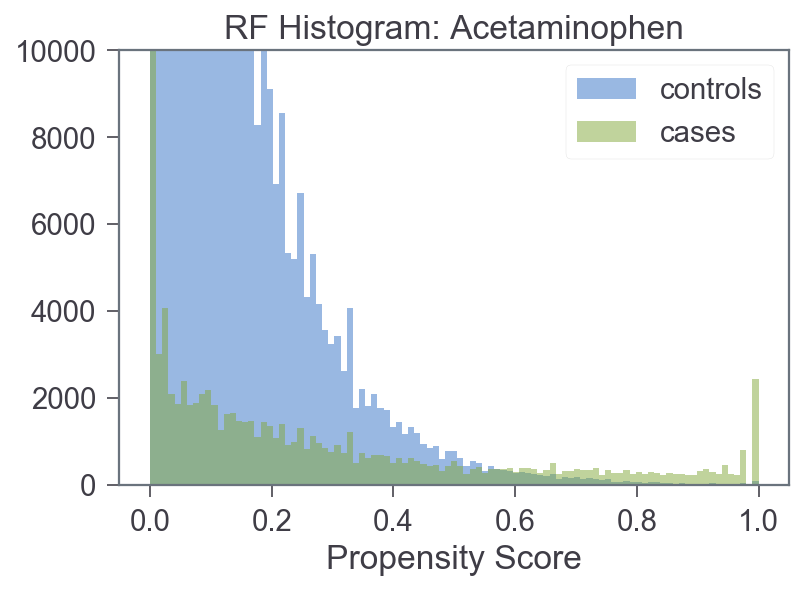

In [165]:
#RANDOM FOREST HIST

# cases/controls with propensity
cases = df_PSM_acet.query('{}==1'.format(drug))
controls = df_PSM_acet.query('{}==0'.format(drug))

# hist 
bins = np.linspace(0, 1, 100)
plt.hist(controls.Propensity_RF, bins, alpha=0.5, label='controls')
plt.hist(cases.Propensity_RF, bins, alpha=0.5, label='cases')
plt.ylim(0,10000)
plt.title("RF Histogram: "+drug)
plt.xlabel("Propensity Score")
plt.legend(loc='upper right')
plt.savefig("{}/RF_100_none".format(drug))
plt.show()

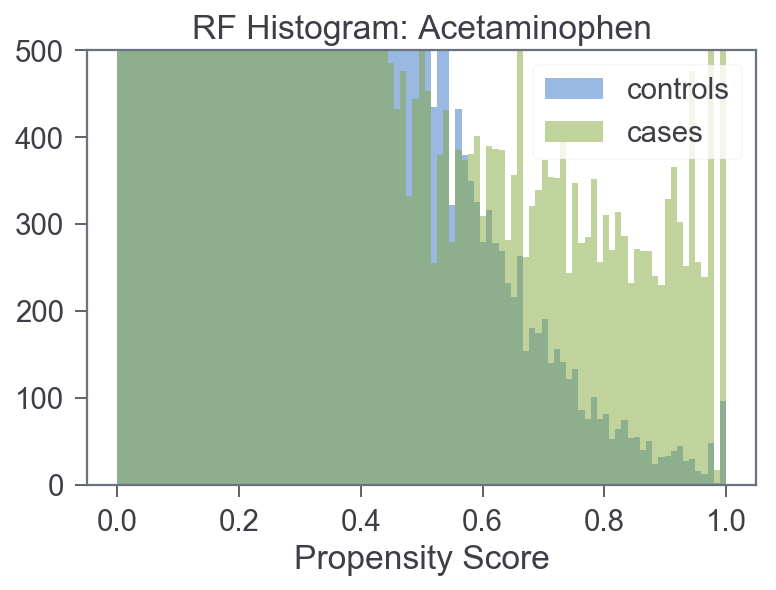

In [136]:
#RANDOM FOREST HIST

# cases/controls with propensity
cases = df_PSM_acet.query('{}==1'.format(drug))
controls = df_PSM_acet.query('{}==0'.format(drug))

# hist 
bins = np.linspace(0, 1, 100)
plt.hist(controls.Propensity_RF, bins, alpha=0.5, label='controls')
plt.hist(cases.Propensity_RF, bins, alpha=0.5, label='cases')
plt.ylim(0,500)
plt.title("RF Histogram: "+drug)
plt.xlabel("Propensity Score")
plt.legend(loc='upper right')
plt.savefig("{}/RF_100_none_Zoom".format(drug))
plt.show()

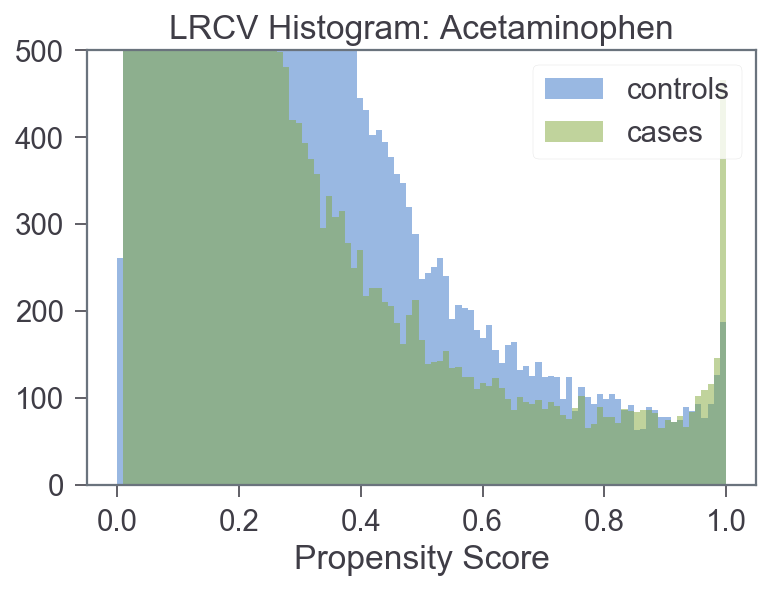

In [128]:
# cases/controls with propensity
cases = df_PSM_acet.query('{}==1'.format(drug))
controls = df_PSM_acet.query('{}==0'.format(drug))

# hist 
bins = np.linspace(0, 1, 100)
plt.hist(controls.Propensity, bins, alpha=0.5, label='controls')
plt.hist(cases.Propensity, bins, alpha=0.5, label='cases')
plt.ylim(0,500)
plt.title("LRCV Histogram: "+drug)
plt.xlabel("Propensity Score")
plt.legend(loc='upper right')
plt.savefig("{}/Histogram_Zoom".format(drug))

In [166]:
propensity_rf.oob_score_

0.9669691564790169

0.8544532820183671


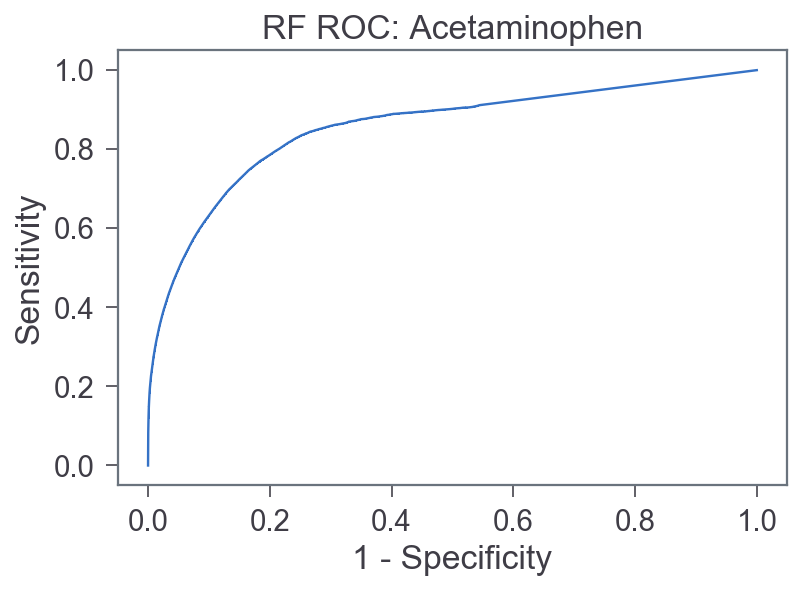

In [170]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
y_true = (df_PSM_acet.get(drug)>0).astype(np.int8).values
y_scores = df_PSM_acet.get('Propensity_RF').values
AUROC_m = roc_auc_score(y_true, y_scores)
print(AUROC_m)

# Plot ROC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
data=pd.DataFrame({'fpr':fpr, 'tpr':tpr})
plt.plot('fpr','tpr', data=data, marker='o',ms=0.1)   
plt.title("RF ROC: "+drug)
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.savefig("{}/RF ROC".format(drug))


#### Matching

In [39]:
drug = 'Aspirin'
scores = pd.read_feather("PSM/{}/LRCV pscores.feather".format(drug))

In [ ]:
def match(df, cal=0.05, minCtrl = 10, numBins = 100):
    allCases = df.copy(deep=True).query('{}==1'.format(drug))
    allControls = df.query('{}==0'.format(drug))
    
    if (len(allCases)<50):
        print('insufficient cases')
        return
    
    allCases['bin'] = pd.cut(allCases.Propensity, numBins)
    mCases, mControls = [], []
    
    for cBin, caseData in allCases.groupby(by='bin'):
        minPS, maxPS = cBin.left, cBin.right
        numCtrl = len(caseData)*minCtrl
        
        controlOptions = allControls.query('Propensity > (@minPS-@cal) and Propensity < (@maxPS+@cal)').get('ID').values
        
        if (len(controlOptions)>minCtrl):
            mCases = np.append(mCases, caseData.get('ID').values)
            mControls = np.append(mControls, (np.random.choice(controlOptions, numCtrl)))
    
    return mCases, mControls

In [ ]:
cases, controls = match(scores)

In [ ]:
df_aeolus[df_aeolus.id.isin([99376162])]

In [ ]:
def selectData(cases, controls, source=df_aeolus, drug=drug):
    selection = []
    ctrl_unique, ctrl_counts = np.unique(controls, return_counts=True)

    for count in np.unique(ctrl_counts):  
        idx = np.where(ctrl_counts==count)
        ctrls = np.take(ctrl_unique, idx)

        toAdd = source[source.id.isin(np.hstack(ctrls))]
        for i in range(0,count): 
                selection.append(toAdd)

    return pd.concat(selection, ignore_index=True)

In [ ]:
df_select = selectData(cases, controls)

In [ ]:
df_select.head()
# do not write dataframe, file too large

## Workspace

### 

In [21]:
df_genderAsso_sig = pd.read_feather(ROOT+"Stages/Significant Gender Associations.feather")
df_drugRisks_sig = pd.read_feather(ROOT+"Stages/Significant Drug Risks.feather").set_index('drug_concept_name')
df_aeolus = pd.read_feather(ROOT + "AEOLUS/clean_withRank.tsv.feather")

In [17]:
drug="Aspirin"

In [ ]:
df_select = pd.read_feather(ROOT + "PSM/aspirin_selected.feather")

In [18]:
def chiSquare(df, drugName=drug):  
    df = df_select

    drugID = df.iloc[:len(df)%1009].query('drug_concept_name==@drugName').get('drug_concept_id').values[0]
    chiResult = []

    df_drug = df.query('drug_concept_id==@drugID')

    M_All = df_drug.query('gender_code=="M"').shape[0]
    F_All = df_drug.query('gender_code=="F"').shape[0]

    if ((not M_All == 0) and (not F_All == 0)):

            for outID in df_drug.get('snomed_outcome_concept_id').unique():

                df_out = df_drug.query('snomed_outcome_concept_id==@outID')

                outName = df_out.iloc[0].get('outcome_concept_name')
                outRank = df_out.iloc[0].get('outcome_rank')

                M_One = df_out.query('gender_code=="M"').shape[0]
                F_One = df_out.query('gender_code=="F"').shape[0]

                if ((not M_One == 0) and (not F_One == 0)):
                    contingencyTable = [[F_One, M_One], [F_All, M_All]]
                else:
                    contingencyTable = [[1, 1], [1, 1]]

                chi2, p, dof, expected = sc.stats.chi2_contingency(contingencyTable)

                cols=['drug_concept_id', 'snomed_outcome_concept_id', 
                      'drug_concept_name', 'outcome_concept_name', 
                      'outcome_rank', 'chi2_stat', 'p_value','M_One',
                      'F_One', 'M_All', 'F_All']
                data = [[drugID, outID, drugName, outName, outRank, 
                         float(chi2), float(p), M_One, F_One, M_All, F_All]]
                chiResult.append(pd.DataFrame(columns=cols, data=data))

    chiResult = pd.concat(chiResult, ignore_index=True)
    return chiResult

In [19]:
df_chi2 = chiSquare(df_select)

In [15]:
# functions 

#Sample Size
def sampleSize(df):
    sampleSizes = df['M_One'] + df['F_One']
    return df.assign(sample_size=sampleSizes)


#Gender Assignment
def gender(df):
    gender_val = df['M_One'] - df['F_One']
    gender_val = gender_val.mask(gender_val > 0, "Male").mask(
        gender_val < 0, "Female").mask(gender_val == 0, "Equal")
    return df.assign(gender=gender_val)


#Bonferroni Correction
def bonferroni(df, colName='p_value'):
    p_values = pd.to_numeric(df[colName])
    bonferroni_pvalues = p_values * len(p_values)
    df = df.assign(newCol=bonferroni_pvalues)
    newCol = 'bonf_' + colName
    return df.rename(columns={'newCol': newCol})


#gender specific reporting odds ratio, likelihood ratio and relative risk (with normalised)
def riskFactor(df, factor, normal=True):
    ALLOWED_FACTORS = ['ROR', 'LR', 'RR']
    if factor not in ALLOWED_FACTORS:
        raise valueError(
            "Invalid factor. Expected one of: %s" % ALLOWED_FACTORS)

    a = df['gender'].mask(df['gender'] == "Male", df['M_One']).mask(
        df['gender'] == "Female", df['F_One']).mask(df['gender'] == "Equal", 1)
    b = df['gender'].mask(df['gender'] == "Male", df['M_All']).mask(
        df['gender'] == "Female", df['F_All']).mask(df['gender'] == "Equal", 1)
    b = b - a
    c = df['gender'].where(df['gender'] == "Male", df['M_One']).where(
        df['gender'] == "Female", df['F_One']).mask(df['gender'] == "Equal", 1)
    d = df['gender'].where(df['gender'] == "Male", df['M_All']).where(
        df['gender'] == "Female", df['F_All']).mask(df['gender'] == "Equal", 1)
    d = d - c

    a = a.mask(a == 0, 1)
    b = b.mask(b == 0, 1)
    c = c.mask(c == 0, 1)
    d = d.mask(d == 0, 1)

    
    if (factor == "ROR"):
        x = (a / b) / (c / d)
    elif (factor == "LR"):
        x = (a / (a + c)) / (b / (b + d))
    elif (factor == "RR"):
        x = (a / (a + b)) / (c / (c + d))

    x = pd.to_numeric(x)
    name = "gender_" + factor
    df = df.assign(new=x).rename(columns={'new': name})
    df.astype(dtype={name:"float64"})
    

    if (normal):
        x_normal = (x - min(x)) / (max(x) - min(x))
        name_normal = "gender_" + factor + "_normal"
        df = df.assign(new_normal=x_normal).rename(
            columns={'new_normal': name_normal})
        df.astype(dtype={name_normal:"float64"})
    
    
    return df

In [16]:
# stats functions 

df_genderAsso = sampleSize(gender(bonferroni(df_chi2)))

for f in ['ROR', 'LR', 'RR']:
    df_genderAsso = riskFactor(df=df_genderAsso, factor=f)

df_genderAsso_sig = df_genderAsso.query('bonf_p_value<=0.05')

In [17]:
#REMOVING ALL GENDER BIASED OUTCOMES FROM DF  

def removeBiasedOutcomes(df):
    outcomeNames = df['outcome_concept_name'].unique()
    ls_outToIgnore = []
    for name in outcomeNames:
        if (re.search(
                'pregnan|lactat|vagina|female|breast|contracep|ovary|miscarr|menopaus',
                name, re.IGNORECASE)):
            ls_outToIgnore = np.append(ls_outToIgnore, name)
        if (re.search('prostate|penis|ejac|testoster', name, re.IGNORECASE)):
            ls_outToIgnore = np.append(ls_outToIgnore, name)
        if (re.search('fetus|fetal|neonat|antenat|gestati|birth', name,
                      re.IGNORECASE)):
            ls_outToIgnore = np.append(ls_outToIgnore, name)
        if (re.search(
                'traffic|gunshot|homicide|education|noncompliance|error|annual.review',
                name, re.IGNORECASE)):
            ls_outToIgnore = np.append(ls_outToIgnore, name)
    return df[-df['outcome_concept_name'].isin(ls_outToIgnore)]


df_genderAsso_sig = removeBiasedOutcomes(df_genderAsso_sig)

In [18]:
#ADDING MANUALLY MAPPED RANKS FOR MISSING DATA 

def addDictRanks(df, rankDict, rankData):
    for i in df.index:
        currentRank = df.at[i, 'outcome_rank']
        if ((currentRank == -1) or (currentRank == 0)):
            searchName = df.at[i, 'outcome_concept_name']
            rankName = rankDict.query('outcome_concept_name==@searchName')['crowdsourced_name']
            if (not rankName.empty):
                rankName = rankName.item()
                newRank = outRank.query('Name==@rankName')['Rank score']
                df.at[i, 'outcome_rank'] = newRank


outRank = pd.read_excel(ROOT + 'Outcome Severity Mapping/Ranked ADRs.xlsx', sheet_name='Ranked ADRs')
df_rankDict = pd.read_feather(ROOT + "Outcome Severity Mapping/Outcomes Dictionary.feather")
addDictRanks(df_genderAsso_sig, rankDict=df_rankDict, rankData=outRank)

In [41]:
# Check if outcome ranks are missing and if yes, set up regEx search 

outRank = pd.read_excel(ROOT + 'Outcome Severity Mapping/Ranked ADRs.xlsx', sheet_name='Ranked ADRs')
df_rankDict = pd.read_feather(ROOT +"Outcome Severity Mapping/Outcomes Dictionary.feather")
rankNames = outRank.Name.unique()
rankNames = np.sort(rankNames)

toDo = df_genderAsso_sig.query('outcome_rank==0').reset_index()['outcome_concept_name'].unique()
done = df_rankDict['outcome_concept_name']

for i in range(0, len(done)):
    idx = np.argwhere(toDo == done[i])
    toDo = np.delete(toDo, idx)
#done = done[-1:]
if (len(toDo) == 0):
    print("All Done :)")
else:
    search = toDo[0]
    print(search)

All Done :)


In [19]:
df_genderAsso_sig.reset_index().drop('index',1).to_feather(ROOT+"PSM/Significant Gender Associations.feather")

In [21]:
df_genderAsso_sig = pd.read_feather(ROOT+"PSM/Significant Gender Associations.feather")

In [13]:
df_genderAsso_sig[['outcome_rank']] = df_genderAsso_sig[['outcome_rank']].replace(-1, 0.5)

# !!!!!!!!! PROBLEM !!!!!!!!!! -1 outcome ranks!!!!!!! 

In [14]:
df_drugRisks = getRiskRatios(riskCalc(df_genderAsso_sig))
df_drugRisks_sig = addDrugID(assignGender(removeConflicts(df_drugRisks)))
df_drugRisks_sig.reset_index().to_feather(ROOT+"PSM/Significant Drug Risks.feather")

In [15]:
df_drugRisks_sig

,risk_ROR,risk_RORn,risk_LR,risk_LRn,risk_RR,risk_RRn,gender,drug_concept_id
drug_concept_name,,,,,,,,
Aspirin,-0.652677,-0.905981,-0.250515,-0.435845,-0.6525,-0.905783,Female,1112807


In [ ]:
def riskRatio(df):
    

In [16]:
risk = riskCalc(df_genderAsso_sig).get(['drug_concept_name','outcome_concept_name','gender','risk_ROR', 'risk_RORn', 'risk_LR', 'risk_LRn', 'risk_RR', 'risk_RRn']).groupby('gender').sum()

In [ ]:
#conflict
x = assignGender(pd.DataFrame(np.log10(risk.T.eval('Male/Female'))).T).rename(index={0:drug})
x.risk_ROR = 3
getConflicts(x)

In [31]:
#comparisons

df = asp
df.groupby(by='gender').count()

,drug_concept_id,snomed_outcome_concept_id,drug_concept_name,outcome_concept_name,outcome_rank,chi2_stat,p_value,M_One,F_One,M_All,F_All,bonf_p_value,sample_size,gender_ROR,gender_ROR_normal,gender_LR,gender_LR_normal,gender_RR,gender_RR_normal
gender,,,,,,,,,,,,,,,,,,,
Female,115,115,115,115,115,115,115,115,115,115,115,115,115,115,115,115,115,115,115
Male,132,132,132,132,132,132,132,132,132,132,132,132,132,132,132,132,132,132,132


In [37]:
df = prev.query('drug_concept_name == "Aspirin"')
df.groupby(by='gender').count()

,drug_concept_id,snomed_outcome_concept_id,drug_concept_name,outcome_concept_name,ROR,outcome_rank,chi2_stat,p_value,M_One,F_One,...,gender_RR,gender_RR_normal,gender_ADR,chi2_ADR,ROR_ADR,LR_ADR,RR_ADR,ROR_normal_ADR,LR_normal_ADR,RR_normal_ADR
gender,,,,,,,,,,,,,,,,,,,,,
Female,73,73,73,73,73,73,73,73,73,73,...,73,73,73,72,72,72,72,72,72,72
Male,87,87,87,87,87,87,87,87,87,87,...,87,87,87,87,87,87,87,87,87,87


In [38]:
x = pd.read_feather(ROOT+"Stages/Significant Drug Risks.feather")

In [ ]:
for x in asp.outcome_concept_name.values:
    if x not in prev.outcome_concept_name.values:
        print(x)

In [ ]:
### TEMP

In [34]:
df_aeolus.query('drug_concept_name==@drug').get('drug_concept_id').values.item(0)

1112807

### ADR severity mapping

In [11]:
# EXACT MAPPING OF SNOMED AEOLUS TO SNOMED 

df_adr = pd.read_feather(ROOT + "AEOLUS/adrIDadrName_unique.feather")\
            .rename(columns={"snomed_outcome_concept_id":"snomed_id","outcome_concept_name":"snomed_name"})

df_sevMap = pd.read_csv(ROOT + "Severity Mapped.csv")\
            .drop(labels=['source_code', 'source_concept_id', 'source_vocabulary_id','valid_start_date', 'valid_end_date', 'invalid_reason', 'target_vocabulary_id'], axis=1)\
            .rename(columns={"source_code_description":"severity_name","target_concept_id":"snomed_id"})

df_severity = pd.read_excel(ROOT + "Outcome Severity Mapping/Ranked ADRs.xlsx")\
                .drop(labels=['Rank Stdev (% out 2929)'], axis =1)\
                .rename(columns={"Name":"severity_name","Rank score":"severity_rank"})

notFound = 0
hasSev = df_sevMap.get('snomed_id').tolist()
for idx, data in df_adr.iterrows():
    snoID = data.snomed_id
    if snoID in hasSev:
        sevName = str(df_sevMap.query('snomed_id==@snoID')['severity_name'].values[0])
        sevRank = df_severity.query('severity_name==@sevName')['severity_rank'].values[0]
        df_adr.at[idx,'severity_name'] = sevName
        df_adr.at[idx,'severity_rank'] = sevRank
    else:
        notFound+=1

# latest run notFound = 1346

df_adr.to_csv(ROOT + "Outcome Severity Mapping/SNOMED Mapped Severity.csv")


In [12]:
df_adr = df_adr.fillna(value=-1)
failed = df_adr.query('severity_rank==-1').get('snomed_name').values

In [23]:
ancestor = pd.read_csv(ROOT+"SNOMED Athena/CONCEPT_ANCESTOR.csv", delimiter='\t')
cClass = pd.read_csv(ROOT+"SNOMED Athena/CONCEPT_CLASS.csv", delimiter='\t')
relation = pd.read_csv(ROOT+"SNOMED Athena/CONCEPT_RELATIONSHIP.csv", delimiter='\t')
synonym = pd.read_csv(ROOT+"SNOMED Athena/CONCEPT_SYNONYM.csv", delimiter='\t')
